In [41]:
!pip install koreanize_matplotlib -q
!pip install statsmodels -q
!pip install konlpy -q
!pip install mecab-python3 -q


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import numpy as np
import koreanize_matplotlib
import warnings
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from konlpy.tag import Okt
import MeCab
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from collections import Counter

warnings.simplefilter(action='ignore')

%config InlineBackend.figure_format = 'retina'

In [42]:
log = pd.read_csv(r'C:\Users\hbyr0\Desktop\가이드액션_기능개선_프로젝트\사이드프로젝트\코드\cleaned_log.csv', index_col=0)

# EDA

In [43]:
# 가이드 액션 사용 로그
guide_action_log = log[log['action_type'].str.contains('guide-')]

# 가이드 액션 사용 유저 로그 추출하기
used_guide_user = guide_action_log['user_uuid'].unique()  # 가이드 액션 사용한 유저 추출
used_guide_user_log = log[log['user_uuid'].isin(used_guide_user)]  # 해당 유저들의 로그 추출

# 가이드 액션 미사용 유저 로그 추출하기
not_used_guide_user_log = log[~log['user_uuid'].isin(used_guide_user)] 

In [44]:
print(f"가이드 액션 사용 유저 수: {guide_action_log['user_uuid'].nunique()} 명") 
print(f"가이드 액션 미사용 유저 수: {log['user_uuid'].nunique() - guide_action_log['user_uuid'].nunique()} 명")  # 전체 유저 수 - 가이드액션 사용 유저 수

print(f"가이드 액션 사용 유저 비율: {round(guide_action_log['user_uuid'].nunique()/ log['user_uuid'].nunique() * 100, 2)} % ") 
print(f"가이드 액션 미사용 유저 비율: {100 - round(guide_action_log['user_uuid'].nunique()/ log['user_uuid'].nunique() * 100, 2)} % ")

가이드 액션 사용 유저 수: 2945 명
가이드 액션 미사용 유저 수: 13658 명
가이드 액션 사용 유저 비율: 17.74 % 
가이드 액션 미사용 유저 비율: 82.26 % 


## 사용, 미사용자 접속 추이

In [45]:
used_guide_user_log['date'] = pd.to_datetime(used_guide_user_log['date'])
not_used_guide_user_log['date'] = pd.to_datetime(not_used_guide_user_log['date'])

In [46]:
used_guide_user_log['y_m'] = used_guide_user_log['date'].dt.strftime('%Y-%m')
not_used_guide_user_log['y_m'] = not_used_guide_user_log['date'].dt.strftime('%Y-%m')

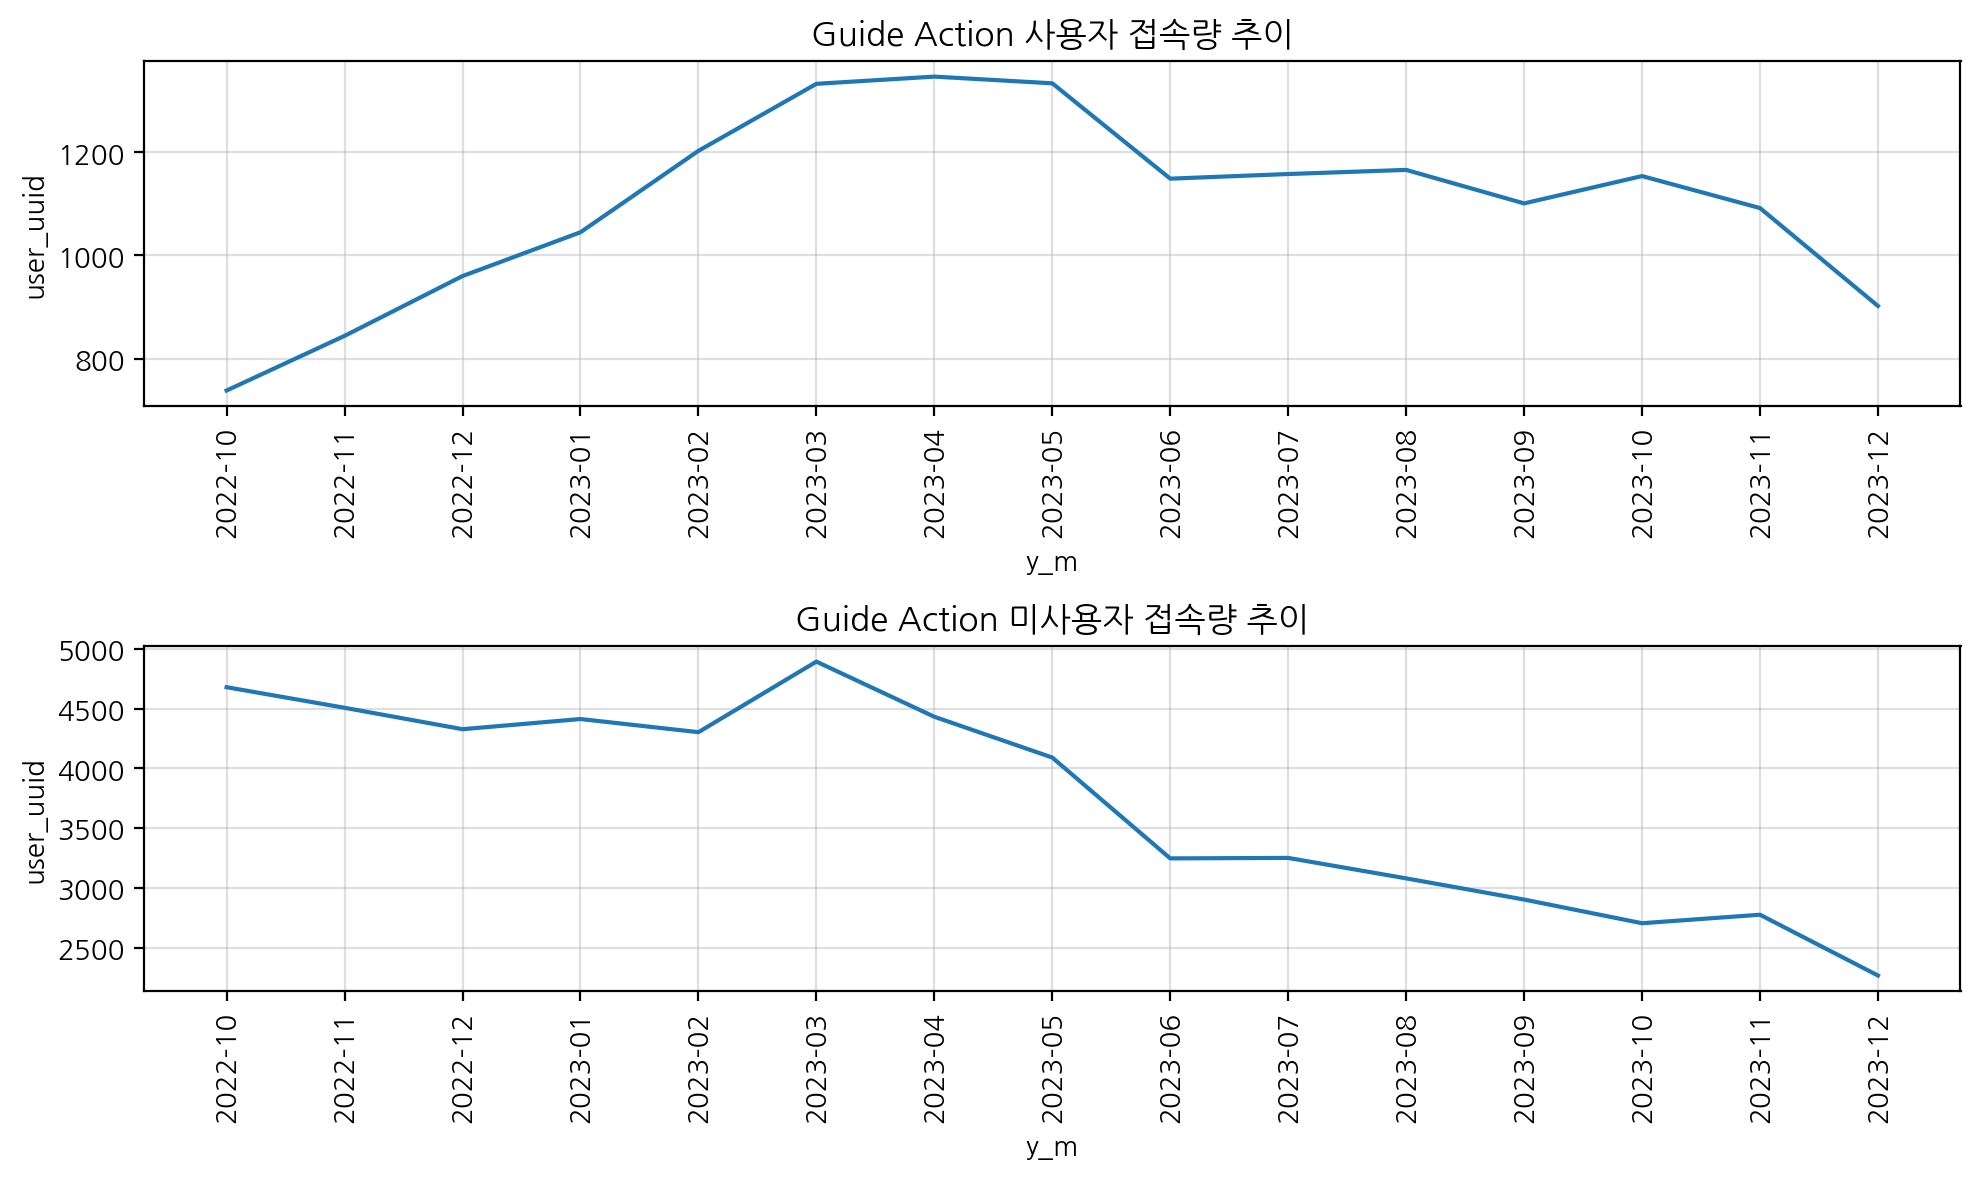

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

sns.lineplot(data=used_guide_user_log.groupby('y_m')['user_uuid'].nunique().reset_index(), x='y_m', y='user_uuid', ax=ax1)
ax1.set_title('Guide Action 사용자 접속량 추이')
ax1.tick_params(axis='x', rotation=90)
ax1.grid(alpha=0.4)

sns.lineplot(data=not_used_guide_user_log.groupby('y_m')['user_uuid'].nunique().reset_index(), x='y_m', y='user_uuid', ax=ax2)
ax2.set_title('Guide Action 미사용자 접속량 추이')
ax2.tick_params(axis='x', rotation=90)
ax2.grid(alpha=0.4)

plt.tight_layout()
plt.show()

## 가이드 액션 이용 여부에 따른 리텐션

In [48]:
first_visit_date = not_used_guide_user_log.groupby('user_uuid')['date'].min().reset_index().rename(columns={'date':'first_date'})

merge = not_used_guide_user_log.merge(first_visit_date, how='left', on='user_uuid')

In [49]:
merge = merge[['user_uuid', 'first_date', 'date']]
merge['first_date'] = pd.to_datetime(merge['first_date'])
merge['date'] = pd.to_datetime(merge['date'])

merge['revisit_days'] = (merge['date'] - merge['first_date']).dt.days
month3_retention_not_user_guide = merge[merge['revisit_days'] <= 90]
month3_retention_not_user_guide.drop_duplicates(['user_uuid', 'revisit_days'], inplace=True)

In [50]:
month3_retention_not_user_guide = (
    month3_retention_not_user_guide
    .groupby('revisit_days')['user_uuid'].count().reset_index()
)

month3_retention_not_user_guide

,revisit_days,user_uuid
0,0,13658
1,1,2237
2,2,1605
3,3,1420
4,4,1310
...,...,...
86,86,521
87,87,490
88,88,465
89,89,490


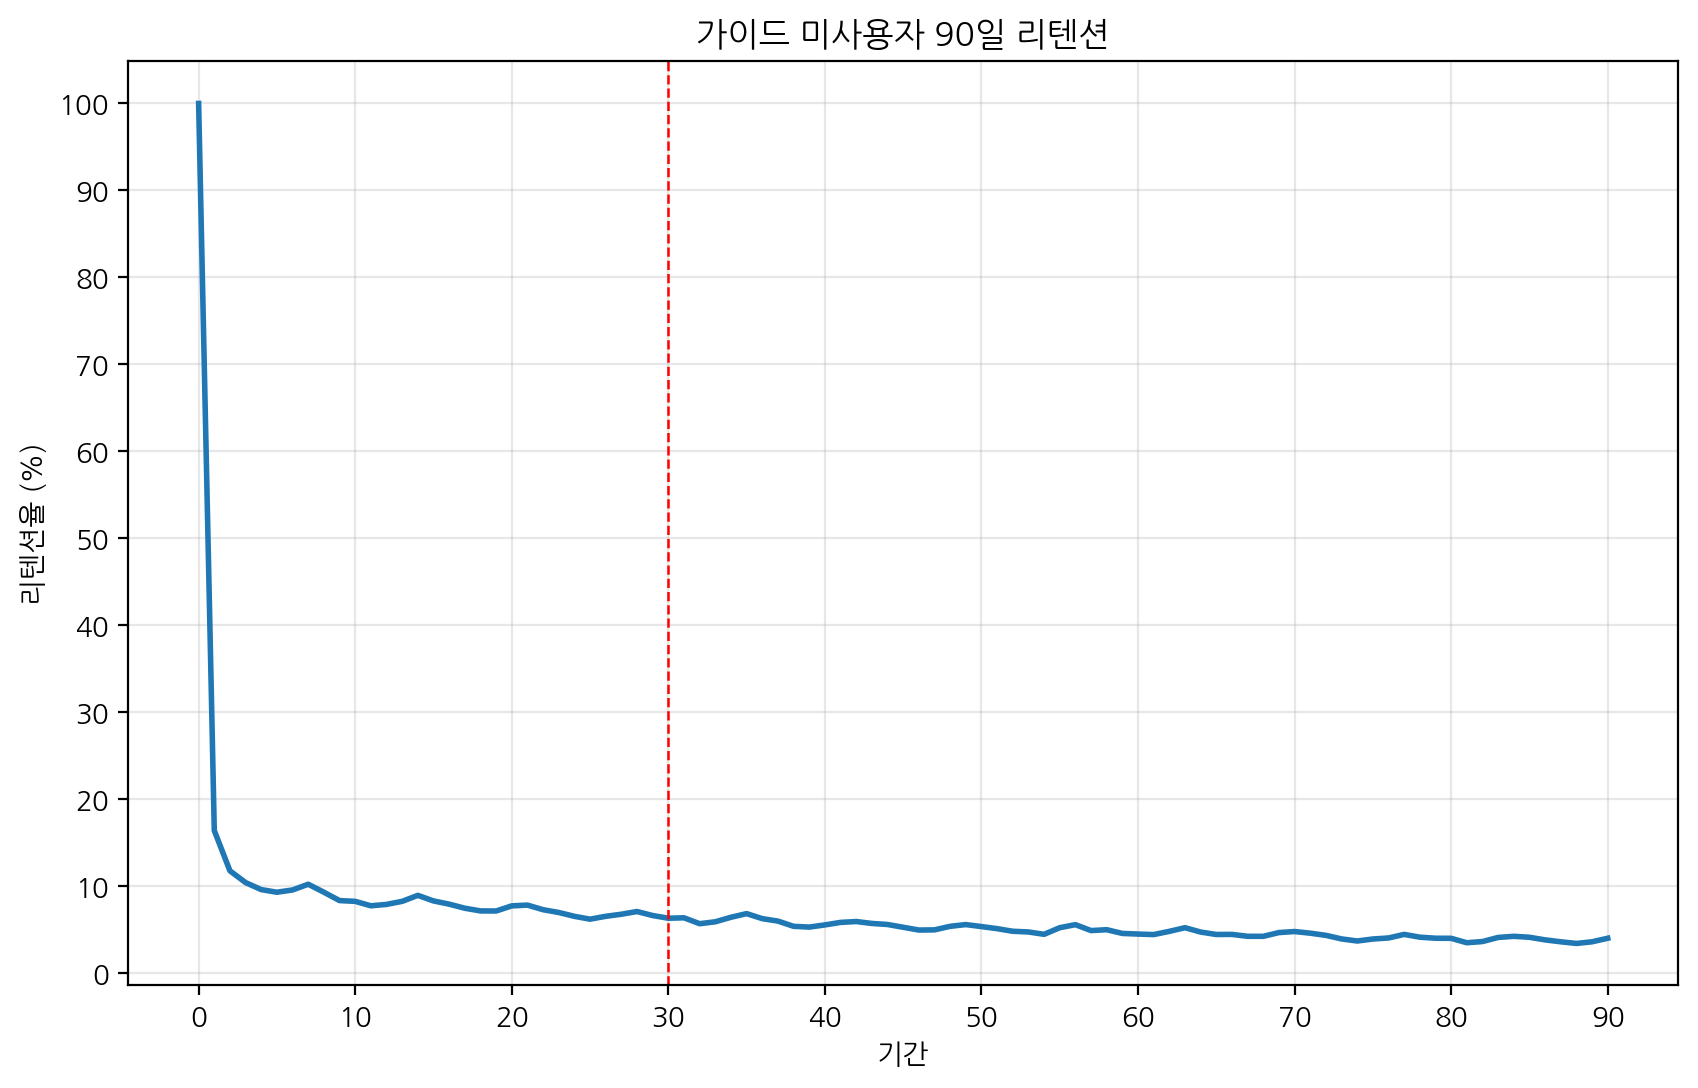

In [51]:
month3_retention_not_user_guide['user_pct'] = month3_retention_not_user_guide['user_uuid'] / month3_retention_not_user_guide[month3_retention_not_user_guide['revisit_days'] == 0]['user_uuid'].values[0]
month3_retention_not_user_guide['user_pct'] = round(month3_retention_not_user_guide['user_pct'] * 100, 2)

plt.figure(figsize=(10,6))
sns.lineplot(month3_retention_not_user_guide, x='revisit_days', y='user_pct', linewidth=2)
plt.title('가이드 미사용자 90일 리텐션')
plt.ylabel('리텐션율 (%)')
plt.xlabel('기간')
plt.grid(alpha=0.3)
plt.yticks(np.arange(0, 101, 10))
plt.xticks(np.arange(0, 91, 10))
plt.axvline(x=30, color='red', linestyle='--', linewidth=0.9)

In [52]:
# 가이드 액션 미이용자 재방문율
not_used_guide_user_log['is_revisit'] = not_used_guide_user_log['date'].notna().astype(int)

In [53]:
# 가이드 액션 이용자 재방문율

# 유저별 첫 guide_action 이용 날짜 구하기
first_guide = (
    used_guide_user_log
    .loc[used_guide_user_log['action_type'].str.contains('guide-')]
    .groupby('user_uuid', as_index=False)['timestamp']
    .min()
    .rename(columns={'timestamp': 'first_guide_time'})
)

# 원본 로그와 병합
merge = used_guide_user_log.merge(first_guide, on='user_uuid', how='left')

# first_guide_time 이후 로그만 필터링
after_guide_log = merge[merge['timestamp'] >= merge['first_guide_time']]

In [54]:
# 유저별 날짜별 정렬
after_guide_log.sort_values(['user_uuid', 'timestamp'], inplace=True)

# 필요한 컬럼만 추출
after_guide_log = after_guide_log[['user_uuid', 'date', 'timestamp', 'session_id', 'action_type', 'first_guide_time']]

In [55]:
# 시간 변환
after_guide_log['first_guide_time'] = pd.to_datetime(after_guide_log['first_guide_time'])
after_guide_log['first_guide_date'] = after_guide_log['first_guide_time'].dt.date
after_guide_log.drop(columns='first_guide_time', inplace=True)

after_guide_log['first_guide_date'] = pd.to_datetime(after_guide_log['first_guide_date'])
after_guide_log['date']  = pd.to_datetime(after_guide_log['date'])

# 재방문일수 차 계산
after_guide_log['revisit_date_diff'] = (after_guide_log['date'] - after_guide_log['first_guide_date']).dt.days

# 유저, 재방문 중복 제거 (간단화)
after_guide_log.drop_duplicates(['user_uuid', 'revisit_date_diff'], inplace=True)


In [56]:
# 3개월 이내 리텐션만 살펴보자
month3_retention_user_guide = after_guide_log[after_guide_log['revisit_date_diff'] <= 90]

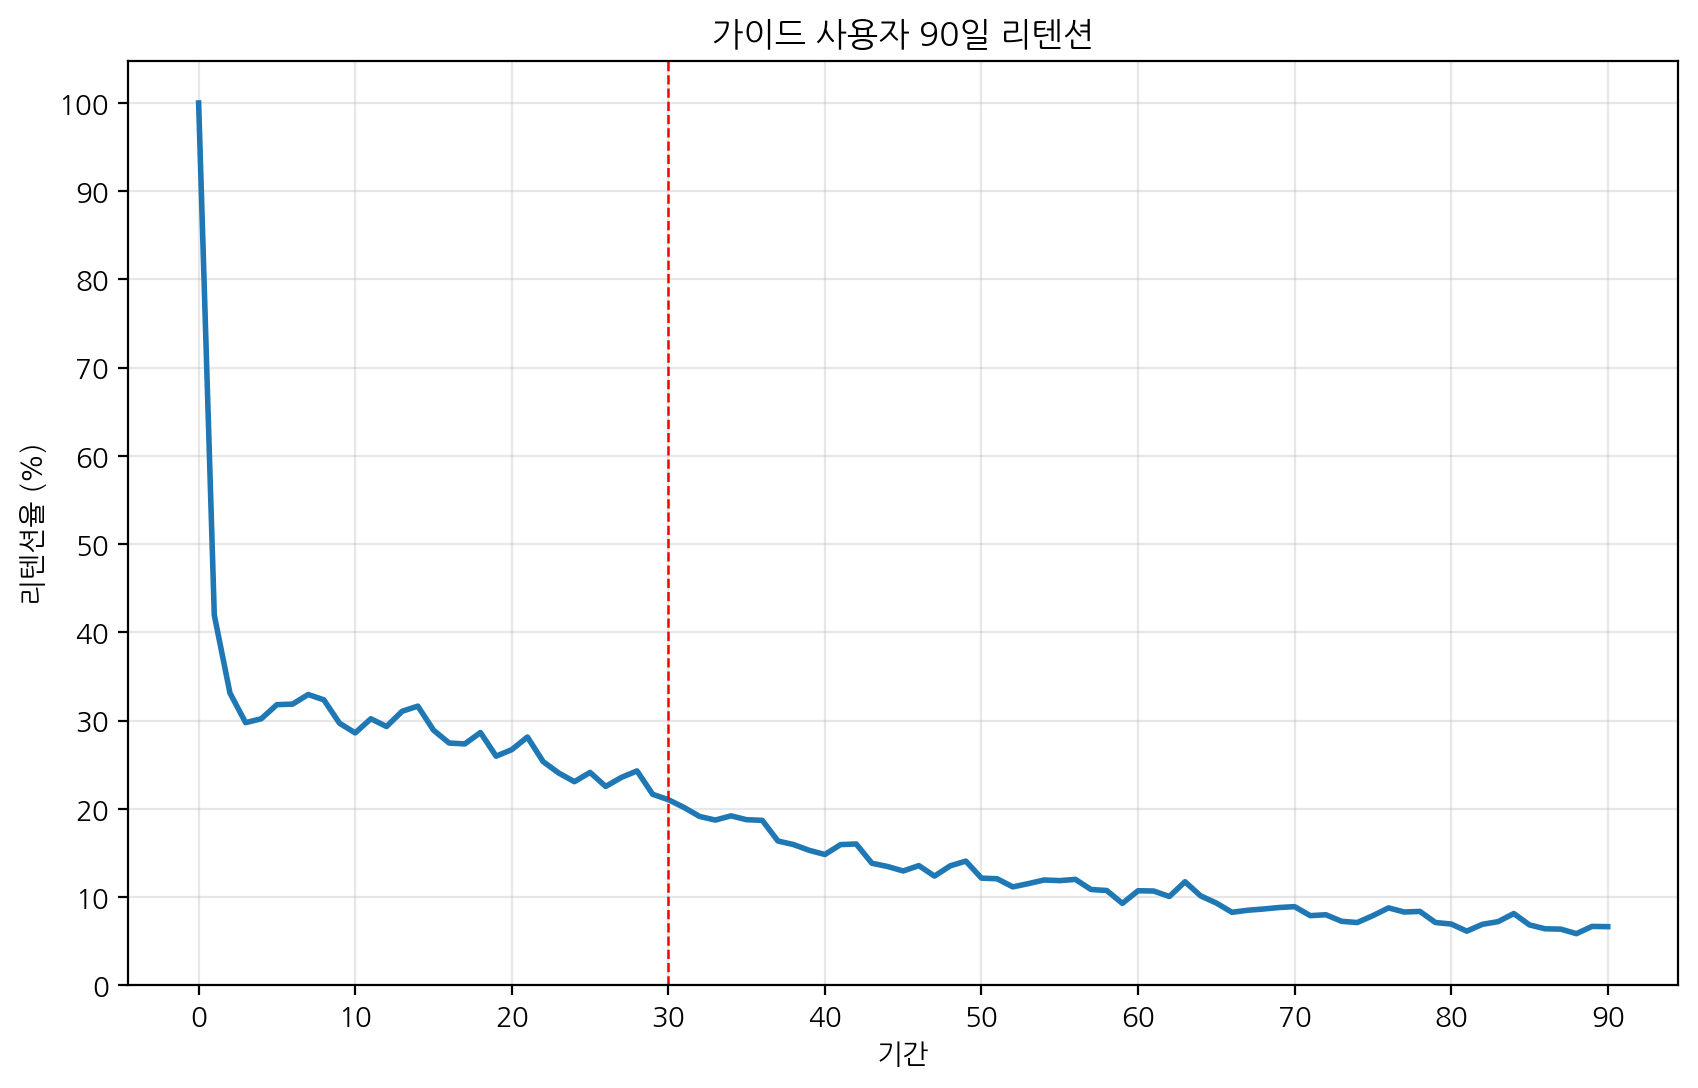

In [57]:
# 시각화
user_guide_retention = (
    month3_retention_user_guide
    .groupby('revisit_date_diff')['user_uuid'].count().reset_index()
    .rename(columns={'user_uuid' : 'user_count'})
)

user_guide_retention['user_pct'] = user_guide_retention['user_count'] / user_guide_retention.loc[user_guide_retention['revisit_date_diff']==0, 'user_count'].values[0]
user_guide_retention['user_pct'] = round(user_guide_retention['user_pct'] * 100, 2)

plt.figure(figsize=(10,6))
sns.lineplot(user_guide_retention, x='revisit_date_diff', y='user_pct', linewidth=2)
plt.title('가이드 사용자 90일 리텐션')
plt.ylabel('리텐션율 (%)')
plt.xlabel('기간')
plt.grid(alpha=0.3)
plt.yticks(np.arange(0, 101, 10))
plt.xticks(np.arange(0, 91, 10))
plt.axvline(x=30, color='red', linestyle='--', linewidth=0.9)

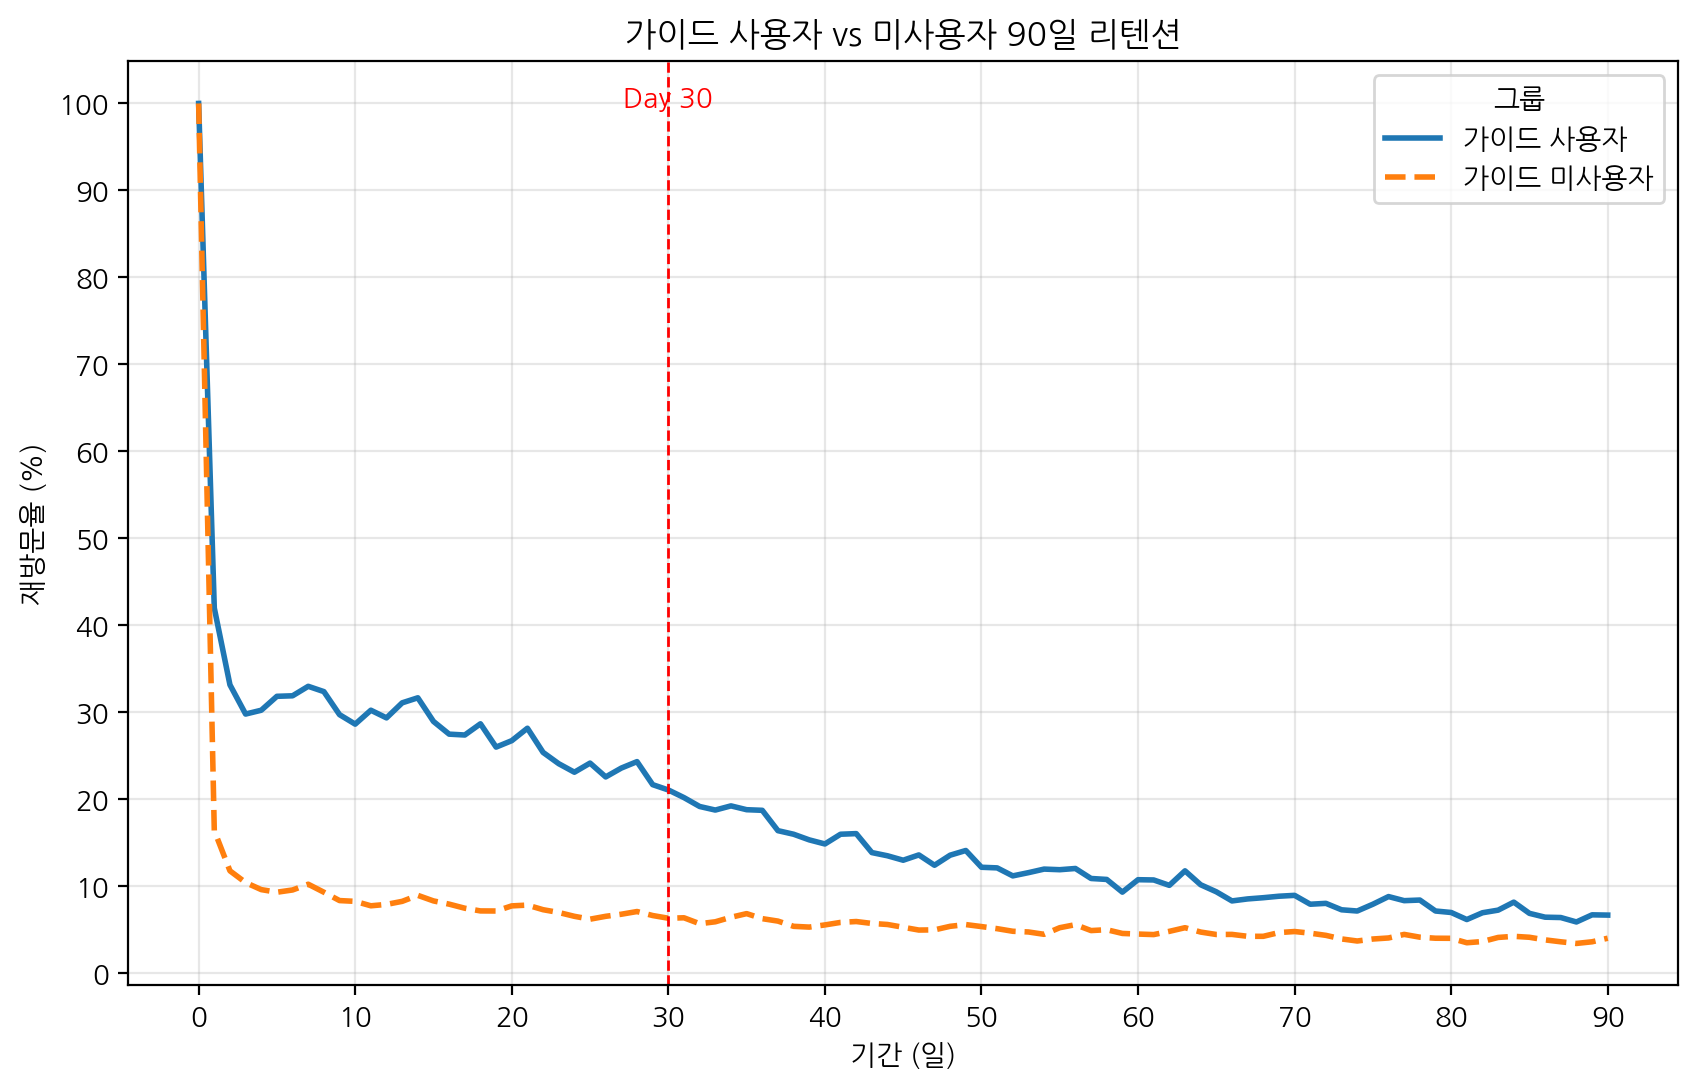

In [58]:
plt.figure(figsize=(10,6))

# 가이드 사용자
sns.lineplot(
    data=user_guide_retention,
    x='revisit_date_diff',
    y='user_pct',
    label='가이드 사용자',
    linewidth=2
)

# 가이드 미사용자
sns.lineplot(
    data=month3_retention_not_user_guide,
    x='revisit_days',
    y='user_pct',
    label='가이드 미사용자',
    linewidth=2,
    linestyle='--'
)

# 공통 설정
plt.title('가이드 사용자 vs 미사용자 90일 리텐션')
plt.ylabel('재방문율 (%)')
plt.xlabel('기간 (일)')
plt.yticks(np.arange(0, 101, 10))
plt.xticks(np.arange(0, 91, 10))
plt.grid(alpha=0.3)

# 30일 기준선
plt.axvline(x=30, color='red', linestyle='--', linewidth=1)
plt.text(30, plt.ylim()[1]*0.95, 'Day 30', color='red', ha='center')

# 범례
plt.legend(title='그룹', loc='upper right')

plt.show()


## 가이드 액션 이용 여부에 따른 체류시간 차이

In [59]:
# 가이드 액션 미이용자 체류시간

# 체류시간 측정에 필요한 컬럼만 추출
not_used_guide_user_log = not_used_guide_user_log[['user_uuid', 'timestamp', 'time_diff', 'session_id', 'action_type']]

# 시간차 소수점 2자리수까지만 표기(가시성)
not_used_guide_user_log['time_diff'] = round(not_used_guide_user_log['time_diff'], 0)

In [60]:
not_used_guide_user_log['row_rank'] = not_used_guide_user_log.groupby(['user_uuid', 'session_id']).cumcount()
not_used_guide_user_log.loc[not_used_guide_user_log['row_rank'] == 0, 'time_diff'] = 0

In [61]:
# 가이드 액션 미이용자 세션별 체류시간
not_guide_session_time_diff = not_used_guide_user_log.groupby(['user_uuid', 'session_id'])['time_diff'].sum().reset_index()

# 가이드 액션 미이용자 유저별 총체류시간
not_guide_user_time_diff = not_guide_session_time_diff.groupby('user_uuid')['time_diff'].sum().reset_index()

print(f"가이드 액션 미이용자 세션별 체류시간 통계")
print(f"{not_guide_session_time_diff['time_diff'].describe()}")

print(f" ")
print(f"-"*50)

print(f"가이드 액션 미이용자 유저별 총체류시간 통계 (누적 체류시간)")
print(f"{not_guide_user_time_diff['time_diff'].describe()}")

가이드 액션 미이용자 세션별 체류시간 통계
count    267559.000000
mean        368.249986
std         829.419125
min           0.000000
25%           2.000000
50%          43.000000
75%         303.000000
max       22663.000000
Name: time_diff, dtype: float64
 
--------------------------------------------------
가이드 액션 미이용자 유저별 총체류시간 통계 (누적 체류시간)
count     13658.000000
mean       7213.984332
std       14300.271930
min           0.000000
25%         235.000000
50%        1550.000000
75%        7121.250000
max      196947.000000
Name: time_diff, dtype: float64


In [62]:
# 가이드 액션 이용자 체류시간

# 유저별 첫 guide_action 이용 날짜 구하기
first_guide = (
    used_guide_user_log
    .loc[used_guide_user_log['action_type'].str.contains('guide-')]
    .groupby('user_uuid', as_index=False)['timestamp']
    .min()
    .rename(columns={'timestamp': 'first_guide_time'})
)

# 원본 로그와 병합
merge = used_guide_user_log.merge(first_guide, on='user_uuid', how='left')

# first_guide_time 이후 로그만 필터링
after_guide_log = merge[merge['timestamp'] >= merge['first_guide_time']]

In [63]:
# 체류시간 계산에 필요한 컬럼만 추출
after_guide_log = after_guide_log[['user_uuid', 'timestamp', 'time_diff', 'session_id', 'action_type']]

# 시간차 소수점 아래 2자리수 변경 (가시성)
after_guide_log['time_diff'] = round(after_guide_log['time_diff'], 2)

In [64]:
# 유저, 세션별 가장 첫 기록은 체류시간 0
after_guide_log['row_rank'] = after_guide_log.groupby(['user_uuid', 'session_id']).cumcount()

after_guide_log.loc[after_guide_log['row_rank'] == 0, 'time_diff'] = 0

In [65]:
# 가이드 액션 이용자의 세션당 체류시간
after_guide_session_time_diff = after_guide_log.groupby(['user_uuid', 'session_id'])['time_diff'].sum().reset_index()

# 가이드 액션 이용자의 유저당 총 체류시간
after_guide_user_time_diff = after_guide_session_time_diff.groupby('user_uuid')['time_diff'].sum().reset_index()

print(f"가이드 액션 이용자 세션별 체류시간 통계")
print(f"{after_guide_session_time_diff['time_diff'].describe()}")

print(f" ")
print(f"-"*50)

print(f"가이드 액션 이용자 유저별 총체류시간 통계 (누적 체류시간)")
print(f"{after_guide_user_time_diff['time_diff'].describe()}")

가이드 액션 이용자 세션별 체류시간 통계
count    108774.000000
mean        449.528241
std         934.122281
min           0.000000
25%           2.730000
50%          53.720000
75%         448.287500
max       30473.560000
Name: time_diff, dtype: float64
 
--------------------------------------------------
가이드 액션 이용자 유저별 총체류시간 통계 (누적 체류시간)
count      2945.000000
mean      16603.390438
std       18875.750208
min           0.000000
25%        3947.050000
50%       10670.830000
75%       22554.300000
max      346110.310000
Name: time_diff, dtype: float64


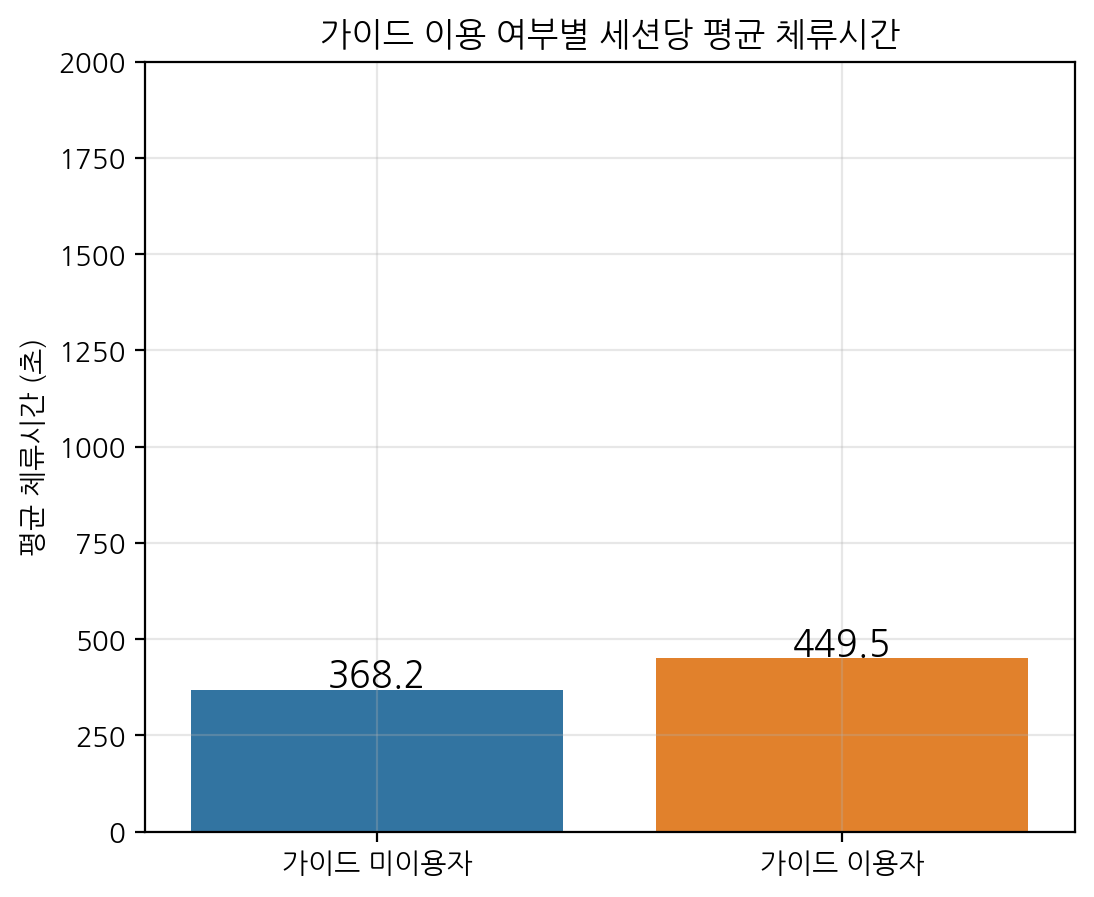

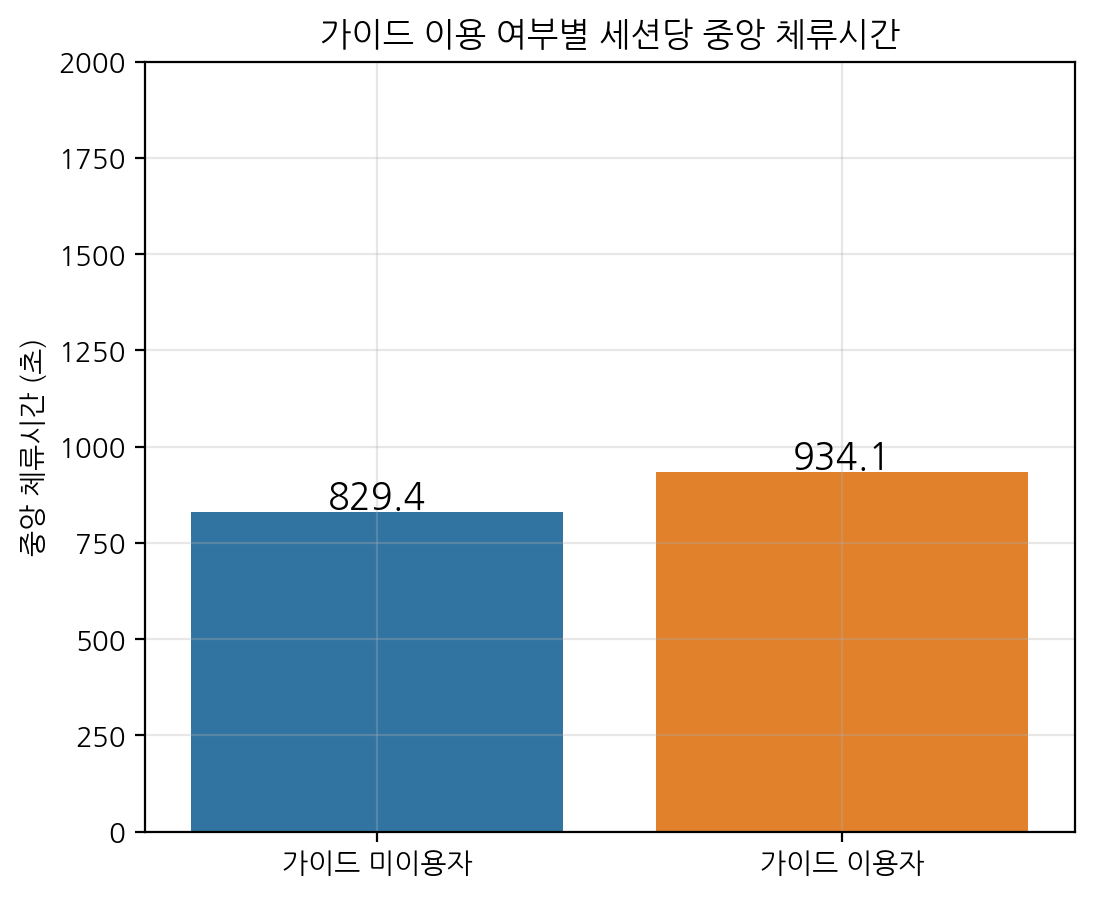

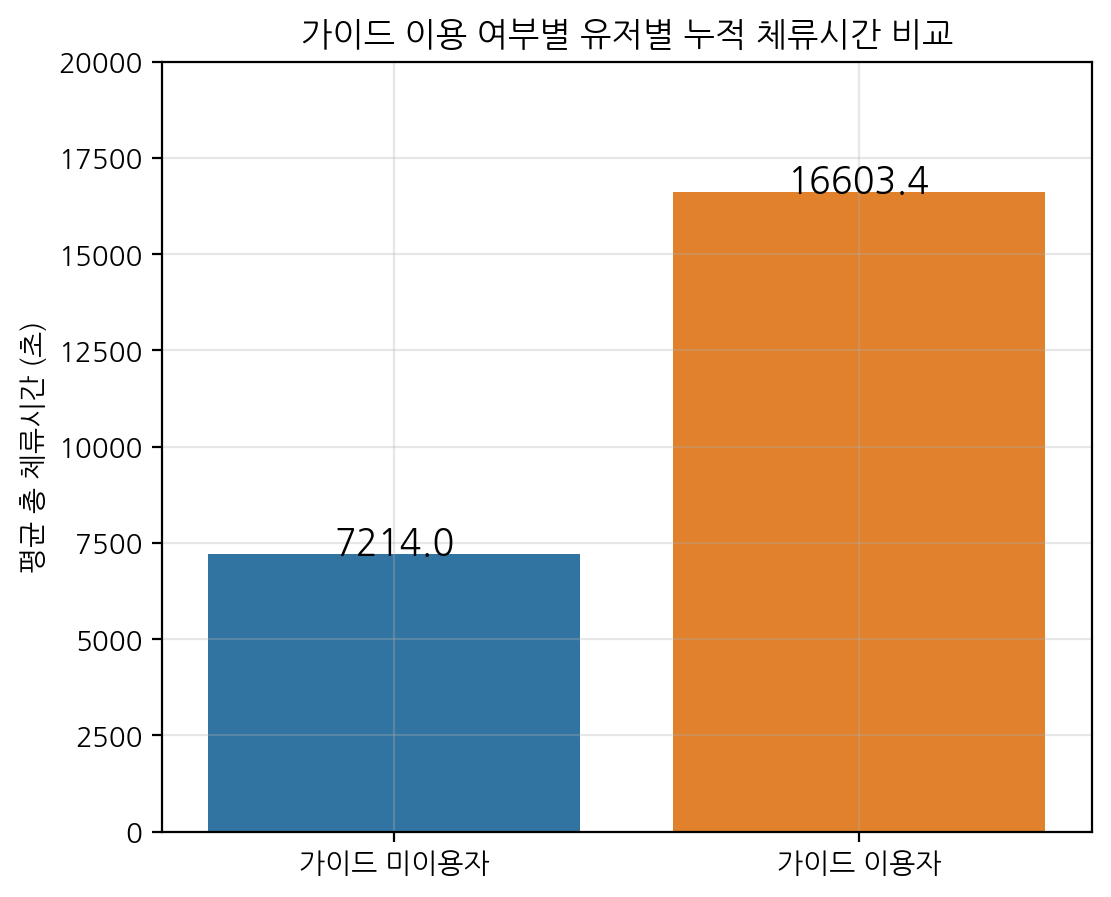

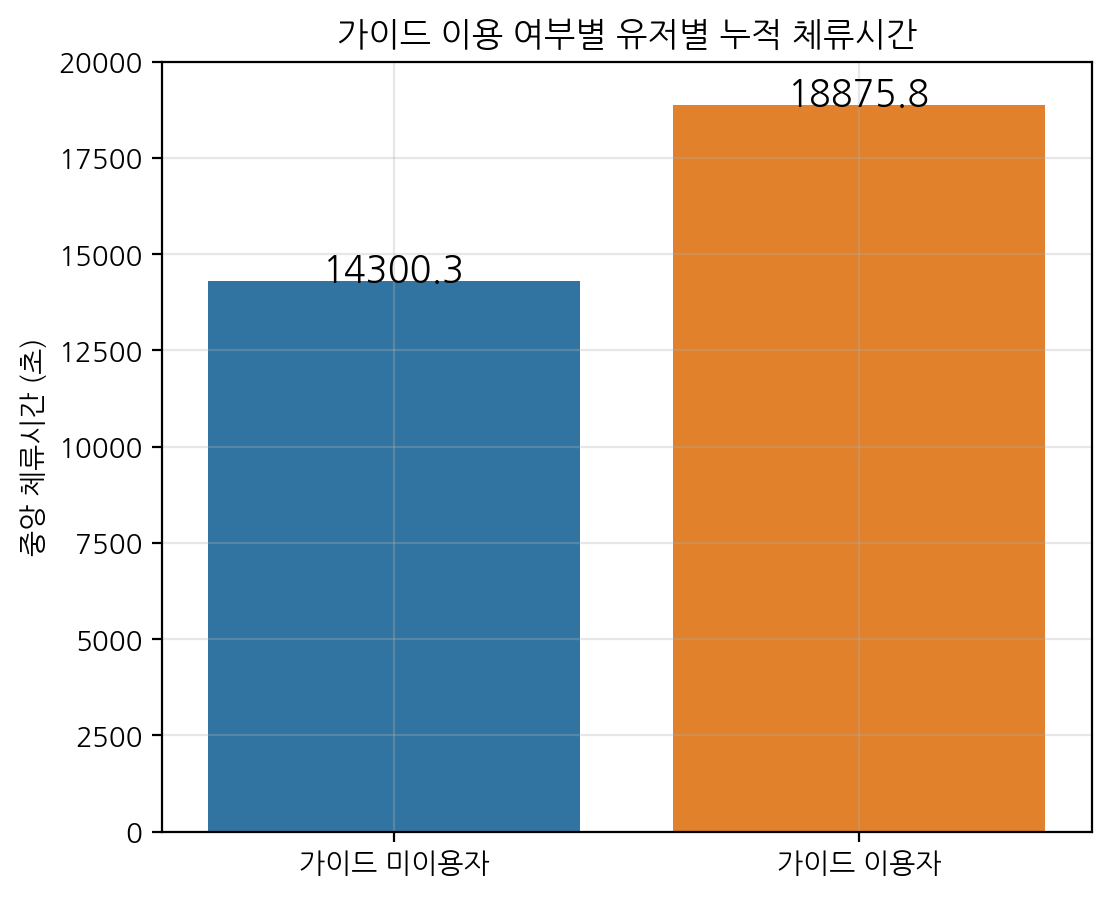

In [66]:
# ------------------------------------
# 1️⃣ 데이터 구성 예시
# ------------------------------------
# 이미 통계치를 계산한 상태라면 아래처럼 샘플 형태로 데이터를 구성
data = {
    'group': ['가이드 미이용자', '가이드 이용자'],
    'session_mean': [368.25, 449.53],
    'session_std' : [829.42, 934.12],
    'user_total_mean': [7213.98, 16603.39],
    'user_total_std' : [14300.27, 18875.75]
}
df = pd.DataFrame(data)


# 세션별 평균 체류시간
plt.figure(figsize=(6,5))
sns.barplot(data=df, x='group', y='session_mean', hue='group')
plt.title('가이드 이용 여부별 세션당 평균 체류시간')
plt.xlabel('')
plt.ylabel('평균 체류시간 (초)')
plt.ylim(0, 2000)
plt.grid(alpha=0.3)
for i, v in enumerate(df['session_mean']):
    plt.text(i, v + 10, f'{v:.1f}', ha='center', fontsize=13)
plt.show()

# 세션별 중앙 체류시간
plt.figure(figsize=(6,5))
sns.barplot(data=df, x='group', y='session_std', hue='group')
plt.title('가이드 이용 여부별 세션당 중앙 체류시간')
plt.xlabel('')
plt.ylabel('중앙 체류시간 (초)')
plt.ylim(0, 2000)
plt.grid(alpha=0.3)
for i, v in enumerate(df['session_std']):
    plt.text(i, v + 10, f'{v:.1f}', ha='center', fontsize=13)
plt.show()

# 유저별 평균 누적체류시간
plt.figure(figsize=(6,5))
sns.barplot(data=df, x='group', y='user_total_mean', hue='group')
plt.title('가이드 이용 여부별 유저별 누적 체류시간 비교')
plt.xlabel('')
plt.ylabel('평균 총 체류시간 (초)')
plt.ylim(0, 20000)
plt.grid(alpha=0.3)
for i, v in enumerate(df['user_total_mean']):
    plt.text(i, v + 10, f'{v:.1f}', ha='center', fontsize=13)
plt.show()

# 유저별 중앙 체류시간
plt.figure(figsize=(6,5))
sns.barplot(data=df, x='group', y='user_total_std', hue='group')
plt.title('가이드 이용 여부별 유저별 누적 체류시간')
plt.xlabel('')
plt.ylabel('중앙 체류시간 (초)')
plt.ylim(0, 20000)
plt.grid(alpha=0.3)
for i, v in enumerate(df['user_total_std']):
    plt.text(i, v + 10, f'{v:.1f}', ha='center', fontsize=13)
plt.show()

## 가이드 액션 이용률

In [68]:
log['action_type'].unique()

array(['etc', 'profile', 'apply-step1', 'apply-step2', 'apply-step3',
       'apply-step4', 'applydone', 'apply-update', 'profile-notify',
       'job-recruit', 'profile-verify', 'companies-view', 'guideclick',
       'signup-click', 'companies-member', 'search', 'apply-progress',
       'signup-done', 'apply-click', 'social', 'profile-setting',
       'job-bookmark', 'companies-bookmark', 'guide-career',
       'guide-specialty', 'guide-language', 'guide-newscard',
       'guide-overview', 'guide-snscard', 'guide-funding'], dtype=object)

In [69]:
print(f"지원자 비율 {log[log['action_type']=='apply-step4']['user_uuid'].nunique() / log['user_uuid'].nunique()*100 :.2f} %")

지원자 비율 39.05 %


In [70]:
print(f"가이드 액션 이용율 : {guide_action_log['user_uuid'].nunique() / log['user_uuid'].nunique()*100 :.2f} %")

가이드 액션 이용율 : 17.74 %


## 가이드 액션 이용 여부에 따른 지원율 차이

```
가이드 액션 사용 여부가 지원율에 영향을 미칠 것이다
```

In [71]:
print(f"가이드 액션 사용 유저 수: {guide_action_log['user_uuid'].nunique()} 명") 
print(f"가이드 액션 미사용 유저 수: {log['user_uuid'].nunique() - guide_action_log['user_uuid'].nunique()} 명")  # 전체 유저 수 - 가이드액션 사용 유저 수

print('-' * 50)
print(f"가이드 액션 사용 유저 비율: {round(guide_action_log['user_uuid'].nunique()/ log['user_uuid'].nunique() * 100, 2)} % ") 
print(f"가이드 액션 미사용 유저 비율: {100 - round(guide_action_log['user_uuid'].nunique()/ log['user_uuid'].nunique() * 100, 2)} % ")

가이드 액션 사용 유저 수: 2945 명
가이드 액션 미사용 유저 수: 13658 명
--------------------------------------------------
가이드 액션 사용 유저 비율: 17.74 % 
가이드 액션 미사용 유저 비율: 82.26 % 


```
1. 가이드 액션 최초 이용 시각
2. 지원서 제출 최초 시각
```

In [98]:
# 가이드 액션 최초 이용 시각
guide_time = (
    log.loc[log['action_type'].str.contains('guide-'), ['user_uuid', 'timestamp']]
    .groupby('user_uuid', as_index=False)['timestamp'].min()
    .rename(columns={'timestamp':'guide_at'})
)

# 지원서 제출 최초 이용 시각
submit_time = (
    log.loc[log['action_type']=='applydone', ['user_uuid', 'timestamp']]
    .groupby('user_uuid', as_index=False)['timestamp'].min()
    .rename(columns={'timestamp':'submit_at'}) 
)

In [99]:
# 유저 모수 만들기
users = pd.DataFrame({'user_uuid' : log['user_uuid'].drop_duplicates()})

In [100]:
user_level = (
    users
        .merge(guide_time, on = 'user_uuid', how = 'left')
        .merge(submit_time, on = 'user_uuid', how = 'left')
)

In [101]:
user_level['guide_used'] = np.where(user_level['guide_at'].notna(), 1, 0)
user_level['submitted'] = np.where(user_level['submit_at'].notna(), 1, 0)

# "제출 이전에 가이드를 사용했는가?" (제출이 없는 경우 False)
user_level['guide_before_submit'] = np.where(
    user_level['guide_at'].notna() & user_level['submit_at'].notna() & 
    (user_level['guide_at'] <= user_level['submit_at']),
    1, 0
)

In [102]:
# 지원 완료한 유저들 추출
submitted_user_level = user_level[user_level['submitted']==1]

# 가이드를 이용하고 지원 완료한 유저
before_submit_user = submitted_user_level[submitted_user_level['guide_before_submit'] == 1]['user_uuid'].nunique()

# 가이드를 이용하지 않고 지원 완료한 유저
not_before_submit_user = submitted_user_level[submitted_user_level['guide_before_submit'] == 0]['user_uuid'].nunique()


print(f"가이드를 이용하고 지원완료한 유저 수 : {before_submit_user} 명")
print(f"가이드를 이용하지않고 지원완료한 유저 수 : {not_before_submit_user} 명")

가이드를 이용하고 지원완료한 유저 수 : 1964 명
가이드를 이용하지않고 지원완료한 유저 수 : 4446 명


In [103]:
print(f"가이드 액션 사용 유저 수: {guide_action_log['user_uuid'].nunique()} 명") 
print(f"가이드 액션 미사용 유저 수: {log['user_uuid'].nunique() - guide_action_log['user_uuid'].nunique()} 명") 

가이드 액션 사용 유저 수: 2945 명
가이드 액션 미사용 유저 수: 13658 명


In [104]:
print(f"가이드를 이용하고 지원완료 비율 : {round(before_submit_user / guide_action_log['user_uuid'].nunique() * 100, 2)} %")

print(f"가이드를 이용하지 않고 지원완료 비율 : {round((not_before_submit_user / (log['user_uuid'].nunique() - guide_action_log['user_uuid'].nunique())) * 100, 2)} %")


가이드를 이용하고 지원완료 비율 : 66.69 %
가이드를 이용하지 않고 지원완료 비율 : 32.55 %


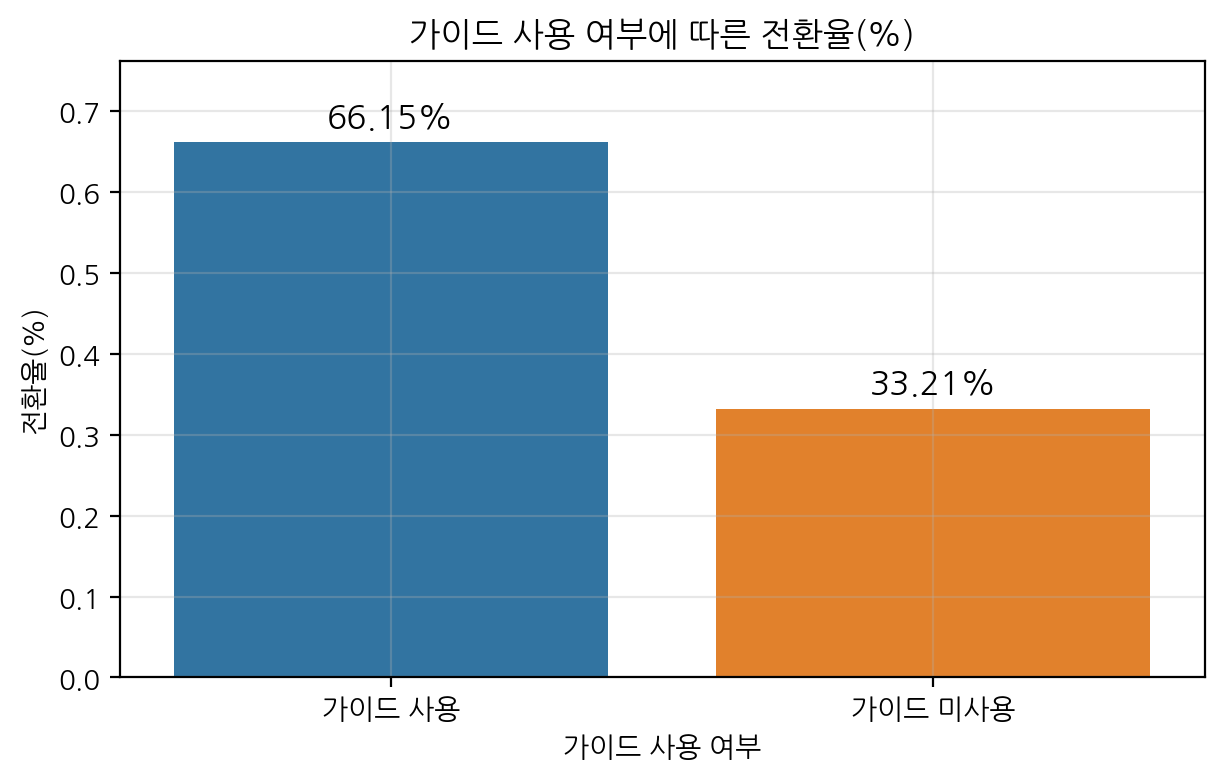

In [105]:
# 시각화
successes = [1948, 4536]
nobs = [2945, 13658]

coversion_rates = np.array(successes) / np.array(nobs)
labels = ['가이드 사용', '가이드 미사용']
colors = ['#63b1ff', '#ff8fd4']


plt.figure(figsize=(7,4))
ax = sns.barplot(x=labels, y=coversion_rates, hue=labels)

plt.title('가이드 사용 여부에 따른 전환율(%)')
plt.ylabel('전환율(%)')
plt.xlabel('가이드 사용 여부')
plt.grid(alpha=0.3)

for i, rate in enumerate(coversion_rates):
    plt.text(i,
              rate + 0.01,
              f'{rate*100:.2f}%',
              ha='center',
              va='bottom',
              fontsize=12
              )

plt.ylim(0, max(coversion_rates) + 0.1)

plt.show()

In [80]:
## 1. 지원별 세션 만들기
## 2. 유저, 지원 세션 별 최초 가이드 이용 표시
## 3. 세션

In [106]:
log['action_type'].unique()

array(['etc', 'profile', 'apply-step1', 'apply-step2', 'apply-step3',
       'apply-step4', 'applydone', 'apply-update', 'profile-notify',
       'job-recruit', 'profile-verify', 'companies-view', 'guideclick',
       'signup-click', 'companies-member', 'search', 'apply-progress',
       'signup-done', 'apply-click', 'social', 'profile-setting',
       'job-bookmark', 'companies-bookmark', 'guide-career',
       'guide-specialty', 'guide-language', 'guide-newscard',
       'guide-overview', 'guide-snscard', 'guide-funding'], dtype=object)

In [109]:
# 가이드 액션 최초 이용 시각
guide_time2 = (
    log.loc[log['action_type'].str.contains('guide-'), ['user_uuid', 'apply_session', 'timestamp']]
    .groupby(['user_uuid','apply_session'], as_index=False)['timestamp'].min()
    .rename(columns={'timestamp':'guide_at'})
)

# 지원서 제출 최초 이용 시각
submit_time2 = (
    log.loc[log['action_type']=='applydone', ['user_uuid', 'apply_session', 'timestamp']]
    .groupby(['user_uuid', 'apply_session'], as_index=False)['timestamp'].min()
    .rename(columns={'timestamp':'submit_at'}) 
)

In [110]:
# 3) 세션 테이블 생성(유저×세션 기준)
sessions = (
    log.groupby(['user_uuid', 'apply_session'], as_index=False)['timestamp']
       .min()
       .rename(columns={'timestamp':'session_start_at'})
    .merge(guide_time2, on=['user_uuid','apply_session'], how='left')
    .merge(submit_time2, on=['user_uuid','apply_session'], how='left')
)

In [111]:
# 4) 전환/가이드 지표
sessions['submitted'] = sessions['submit_at'].notna().astype(int)
sessions['guide_used'] = sessions['guide_at'].notna().astype(int)
sessions['guide_before_submit'] = (
    sessions['guide_at'].notna() & sessions['submit_at'].notna() &
    (sessions['guide_at'] <= sessions['submit_at'])
).astype(int)

In [112]:
sessions.sort_values(['user_uuid', 'apply_session'], inplace=True)

In [114]:
sessions

,user_uuid,apply_session,session_start_at,guide_at,submit_at,submitted,guide_used,guide_before_submit
0,0002535c-eacb-456b-a620-92c917332ba3,0,2022-10-05 21:48:56.527758,NaT,NaT,0,0,0
1,0002535c-eacb-456b-a620-92c917332ba3,1,2022-10-19 10:35:40.794268,NaT,2022-10-19 10:35:40.794268,1,0,0
2,0005769f-54b1-44ab-b6d3-bd9147c006a8,0,2022-11-07 13:42:24.760892,NaT,NaT,0,0,0
3,000681b4-bb66-4ccf-9786-f0066d13a34e,0,2023-12-24 20:54:38.290138,NaT,NaT,0,0,0
4,000b55ad-5c86-438b-a5b0-9ea3a2917789,0,2023-06-21 20:01:34.663903,NaT,NaT,0,0,0
...,...,...,...,...,...,...,...,...
58354,ffff25ca-c1d7-4fc2-891b-b0df92f95092,21,2023-11-29 23:12:05.233143,NaT,2023-11-29 23:12:05.233143,1,0,0
58355,ffff25ca-c1d7-4fc2-891b-b0df92f95092,22,2023-11-29 23:17:08.866758,NaT,2023-11-29 23:17:08.866758,1,0,0
58356,ffff25ca-c1d7-4fc2-891b-b0df92f95092,23,2023-11-29 23:19:58.700245,NaT,2023-11-29 23:19:58.700245,1,0,0
58357,ffff25ca-c1d7-4fc2-891b-b0df92f95092,24,2023-11-29 23:22:41.301150,NaT,2023-11-29 23:22:41.301150,1,0,0


In [113]:
# 세부 기능의 기여도 분석
log['time_diff'] = log['time_diff'].round(3)

In [87]:
# time_diff 소수점 3자리까지
log['time_diff'] = log['time_diff'].round(3)

# timestamp 시간변환
log['timestamp'] = pd.to_datetime(log['timestamp'], format='mixed')

# timestamp UTC문자 제거
log['timestamp'] = log['timestamp'].dt.tz_localize(None)


## Funnel

In [211]:
log2 = log[['user_uuid', 'timestamp', 'action_type', 'session_id']]

###  GPT이용

#### 가이드를 이용한 유저 Funnel

In [231]:
# 0) timestamp 정규화 (열 전체를 UTC 단일 타임존으로)
if not pd.api.types.is_datetime64_any_dtype(log2['timestamp']):
    log2['timestamp'] = pd.to_datetime(log2['timestamp'], errors='coerce', utc=True)
else:
    tz = getattr(log2['timestamp'].dt, 'tz', None)
    if tz is None:
        log2['timestamp'] = log2['timestamp'].dt.tz_localize('UTC')
    elif str(tz) != 'UTC':
        log2['timestamp'] = log2['timestamp'].dt.tz_convert('UTC')

# 1) 단계 라벨링
step = np.select(
    [
        log2['action_type'].eq('guideclick'),
        log2['action_type'].str.startswith('guide-'),
        log2['action_type'].eq('apply-click'),
        log2['action_type'].eq('applydone')
    ],
    ['guide_click', 'guide_use', 'apply_click', 'apply_done'],
    default=None
)
log3 = log2.assign(step=step).dropna(subset=['step'])

# 2) 유저×단계별 최초 발생 시각 피벗
times = (
    log3.groupby(['user_uuid','step'], as_index=False)['timestamp']
        .min()
        .pivot(index='user_uuid', columns='step', values='timestamp')
        .reset_index()
)

# 3) 순서 검증 (클릭 → 사용 → 지원클릭 → 제출)
times['used_after_click'] = (
    times['guide_click'].notna() & times['guide_use'].notna() &
    (times['guide_use'] > times['guide_click'])
)
times['apply_after_use'] = (
    times['used_after_click'] &
    times['apply_click'].notna() &
    (times['apply_click'] > times['guide_use'])
)
times['done_after_apply'] = (
    times['apply_after_use'] &
    times['apply_done'].notna() &
    (times['apply_done'] > times['apply_click'])
)

# 4) 퍼널 요약
base = log['user_uuid'].nunique()                  # 전체 유저 모수
step1 = times['guide_click'].notna().sum()          # 가이드 클릭 경험 유저
step2 = times['used_after_click'].sum()             # (클릭 이후) 가이드 사용 유저
step3 = times['apply_after_use'].sum()              # (사용 이후) 지원 클릭 유저
step4 = times['done_after_apply'].sum()             # (지원클릭 이후) 지원 완료 유저

funnel_summary = pd.DataFrame({
    '단계': ['전체유저', '가이드 클릭', '가이드 기능 사용', '지원 클릭', '지원 완료'],
    '유저수': [base, step1, step2, step3, step4]
})
funnel_summary['전환율(모수대비, %)'] = (funnel_summary['유저수'] / max(base,1) * 100).round(2)
funnel_summary['직전단계→다음단계 전환율(%)'] = funnel_summary['유저수'].div(
    funnel_summary['유저수'].shift(1).replace(0, np.nan)
).mul(100).round(2)

funnel_summary


,단계,유저수,"전환율(모수대비, %)",직전단계→다음단계 전환율(%)
0,전체유저,16603,100.00,NaN
1,가이드 클릭,12347,74.37,74.37
2,가이드 기능 사용,2938,17.70,23.80
3,지원 클릭,1153,6.94,39.24
4,지원 완료,8,0.05,0.69


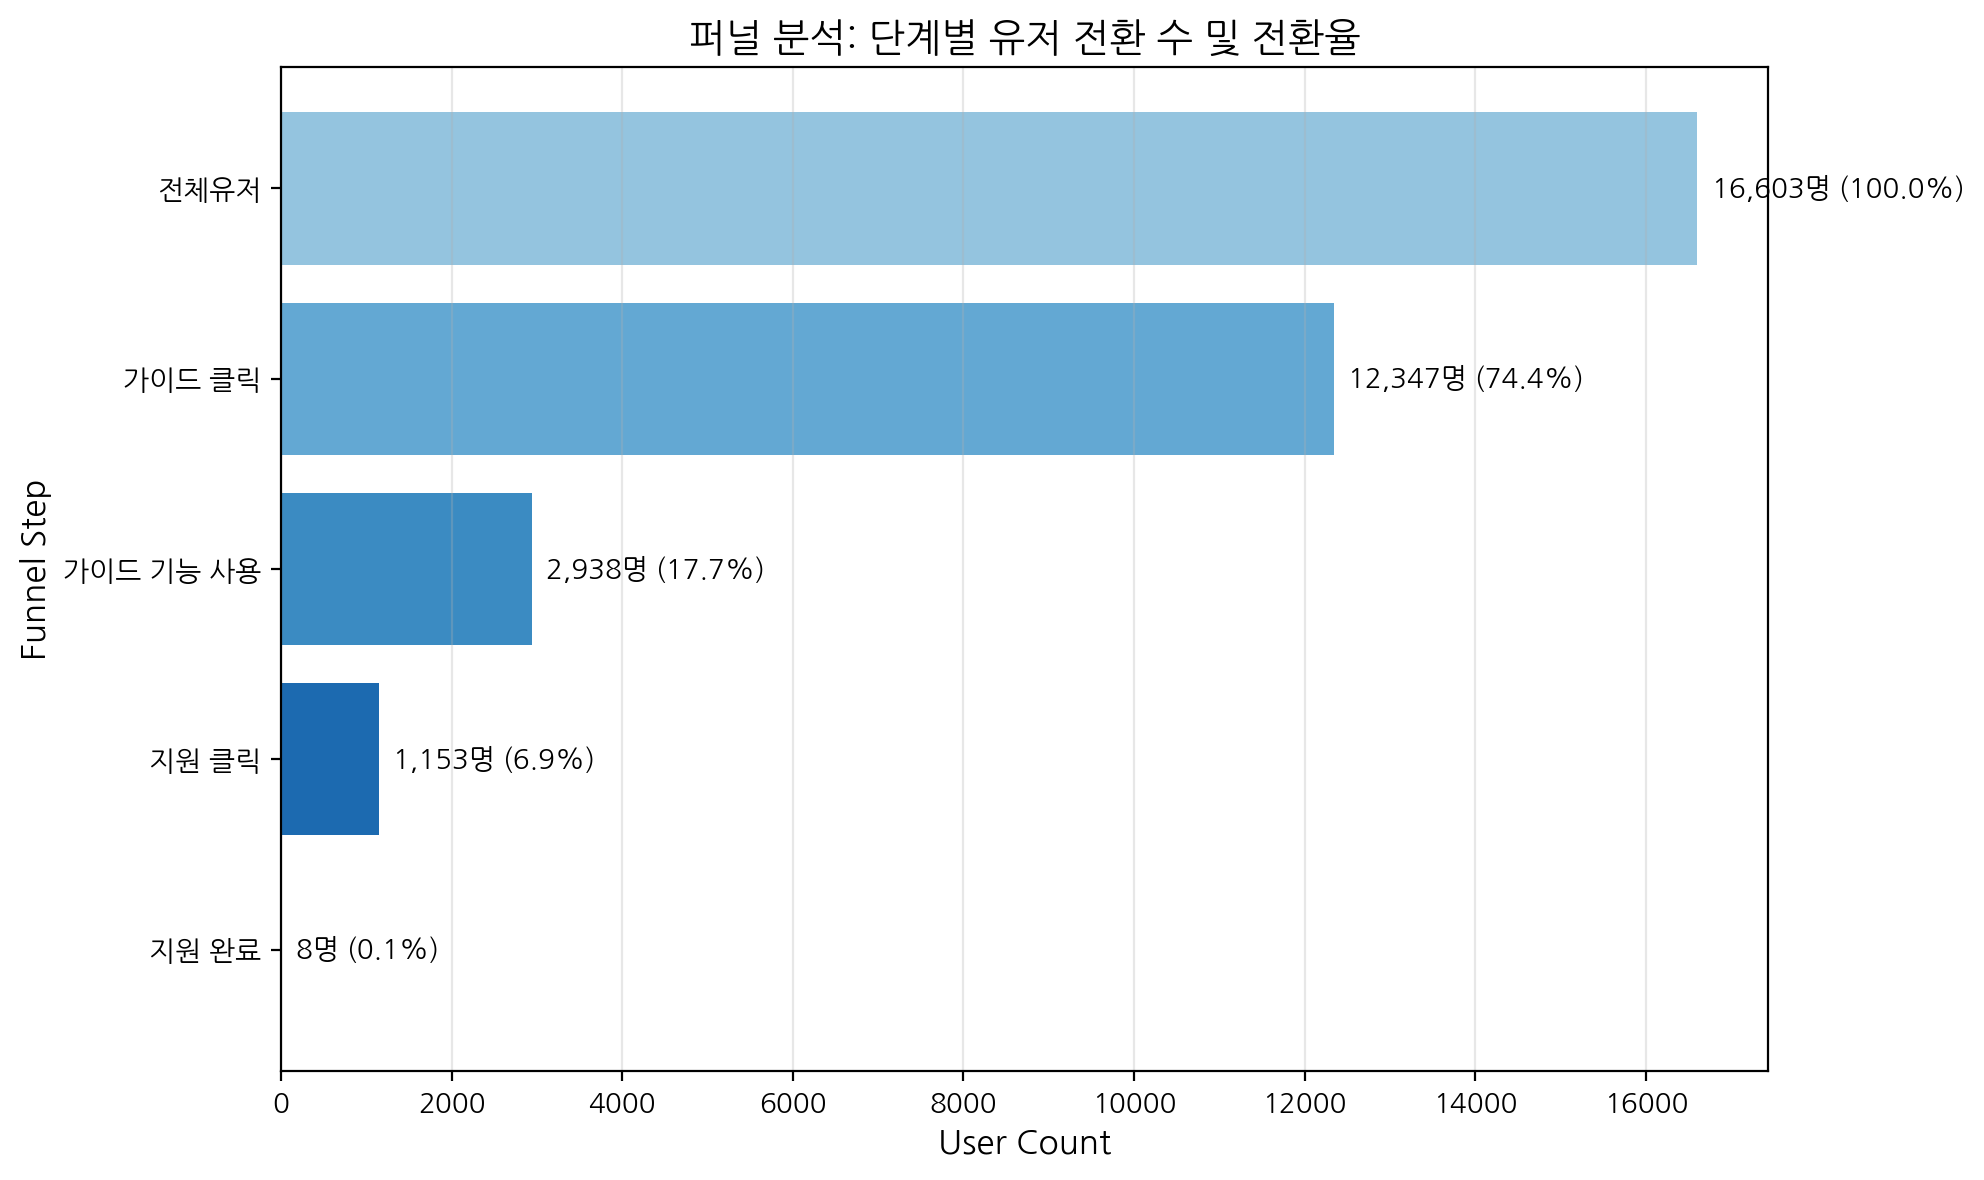

In [232]:
import matplotlib.cm as cm

# 데이터 준비
x = funnel_summary['단계']
y = funnel_summary['유저수']
rate = funnel_summary['전환율(모수대비, %)']

colors = cm.Blues(np.linspace(0.4, 0.9, len(y)))

# 그래프 크기 및 스타일 설정
plt.figure(figsize=(10,6))
bars = plt.barh(x[::-1], y[::-1], color=colors[::-1])  # 단계가 위→아래로 진행되게 뒤집기
plt.title('퍼널 분석: 단계별 유저 전환 수 및 전환율', fontsize=14)
plt.xlabel('User Count', fontsize=12)
plt.ylabel('Funnel Step', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# 값 표시 (예: "3,320명 (15.9%)")
for i, (val, pct) in enumerate(zip(y[::-1], rate[::-1])):
    plt.text(val + max(y)*0.01, i, f"{int(val):,}명 ({pct:.1f}%)", 
             va='center', fontsize=10)

plt.tight_layout()
plt.show()



In [233]:
import pandas as pd
import numpy as np

# 0) timestamp 정규화 (UTC 권장; KST로 보고 싶으면 마지막에 tz_convert)
if not pd.api.types.is_datetime64_any_dtype(log2['timestamp']):
    log2['timestamp'] = pd.to_datetime(log2['timestamp'], errors='coerce', utc=True)
else:
    # tz-naive면 UTC 부여
    if getattr(log2['timestamp'].dt, 'tz', None) is None:
        log2['timestamp'] = log2['timestamp'].dt.tz_localize('UTC')

# 1) 단계 라벨링
# - guide- 로 시작 → guide_use
# - 정확히 guideclick / apply-click / applydone
step = np.select(
    [
        log2['action_type'].eq('guideclick'),
        log2['action_type'].str.startswith('guide-'),
        log2['action_type'].eq('apply-click'),
        log2['action_type'].eq('applydone')
    ],
    ['guide_click','guide_use','apply_click','apply_done'],
    default=None
)

log3 = log2.assign(step=step).dropna(subset=['step'])

# 2) 유저×단계별 "최초 발생 시각" 피벗 (안전: 인덱스 충돌 없음)
times = (
    log3.groupby(['user_uuid','step'], as_index=False)['timestamp']
        .min()
        .pivot(index='user_uuid', columns='step', values='timestamp')
        .reset_index()
)

# 3) 순서 검증 (원하는 시나리오: 클릭 → 사용 → 지원클릭 → 제출)
times['used_after_click'] = (
    times['guide_click'].notna() & times['guide_use'].notna() &
    (times['guide_use'] > times['guide_click'])
)
times['apply_after_use'] = (
    times['used_after_click'] &
    times['apply_click'].notna() &
    (times['apply_click'] > times['guide_use'])
)
times['done_after_apply'] = (
    times['apply_after_use'] &
    times['apply_done'].notna() &
    (times['apply_done'] > times['apply_click'])
)

# 4) 퍼널 요약
base = log['user_uuid'].nunique()
step1 = times['guide_click'].notna().sum()  # 퍼널 시작 母수: 가이드 클릭 유저 수
step2 = times['used_after_click'].sum()
step3 = times['apply_after_use'].sum()
step4 = times['done_after_apply'].sum()

funnel_summary = pd.DataFrame({
    '단계': ['전체유저', '가이드 클릭', '가이드 기능 사용', '지원 클릭', '지원 완료'],
    '유저수': [base, step1, step2, step3, step4]
})
funnel_summary['전환율(모수대비, %)'] = (funnel_summary['유저수'] / max(base,1) * 100).round(2)
funnel_summary['직전단계→다음단계 전환율(%)'] = funnel_summary['유저수'].div(
    funnel_summary['유저수'].shift(1).replace(0,np.nan)
).mul(100).round(2)

print(funnel_summary)


          단계    유저수  전환율(모수대비, %)  직전단계→다음단계 전환율(%)
0       전체유저  16603        100.00               NaN
1     가이드 클릭  12347         74.37             74.37
2  가이드 기능 사용   2938         17.70             23.80
3      지원 클릭   1153          6.94             39.24
4      지원 완료      8          0.05              0.69


#### 가이드를 이용하지 않은 유저의 Funnel

In [234]:
import pandas as pd
import numpy as np

# 1) 단계 라벨링 (지원 클릭 / 지원 완료만)
step = np.select(
    [
        log2['action_type'].eq('apply-click'),
        log2['action_type'].eq('applydone')
    ],
    ['apply_click', 'apply_done'],
    default=None
)
log3 = log2.assign(step=step).dropna(subset=['step'])

# 2) 유저×단계별 최초 발생 시각 피벗
times = (
    log3.groupby(['user_uuid','step'], as_index=False)['timestamp']
        .min()
        .pivot(index='user_uuid', columns='step', values='timestamp')
        .reset_index()
)

# 3) 순서 검증: 지원 클릭 후 제출
times['clicked'] = times['apply_click'].notna()
times['done_after_apply'] = (
    times['apply_click'].notna() &
    times['apply_done'].notna() &
    (times['apply_done'] > times['apply_click'])
)

# 4) 퍼널 요약 (모수=전체 유저 수)
base = log2['user_uuid'].nunique()
step1 = times['clicked'].sum()
step2 = times['done_after_apply'].sum()

funnel_summary = pd.DataFrame({
    '단계': ['전체 유저', '지원 클릭', '지원 완료'],
    '유저수': [base, step1, step2]
})
funnel_summary['전환율(모수대비, %)'] = (funnel_summary['유저수'] / max(base, 1) * 100).round(2)
funnel_summary['직전단계→다음단계 전환율(%)'] = funnel_summary['유저수'].div(
    funnel_summary['유저수'].shift(1).replace(0, np.nan)
).mul(100).round(2)

funnel_summary

,단계,유저수,"전환율(모수대비, %)",직전단계→다음단계 전환율(%)
0,전체 유저,16603,100.00,NaN
1,지원 클릭,3095,18.64,18.64
2,지원 완료,15,0.09,0.48


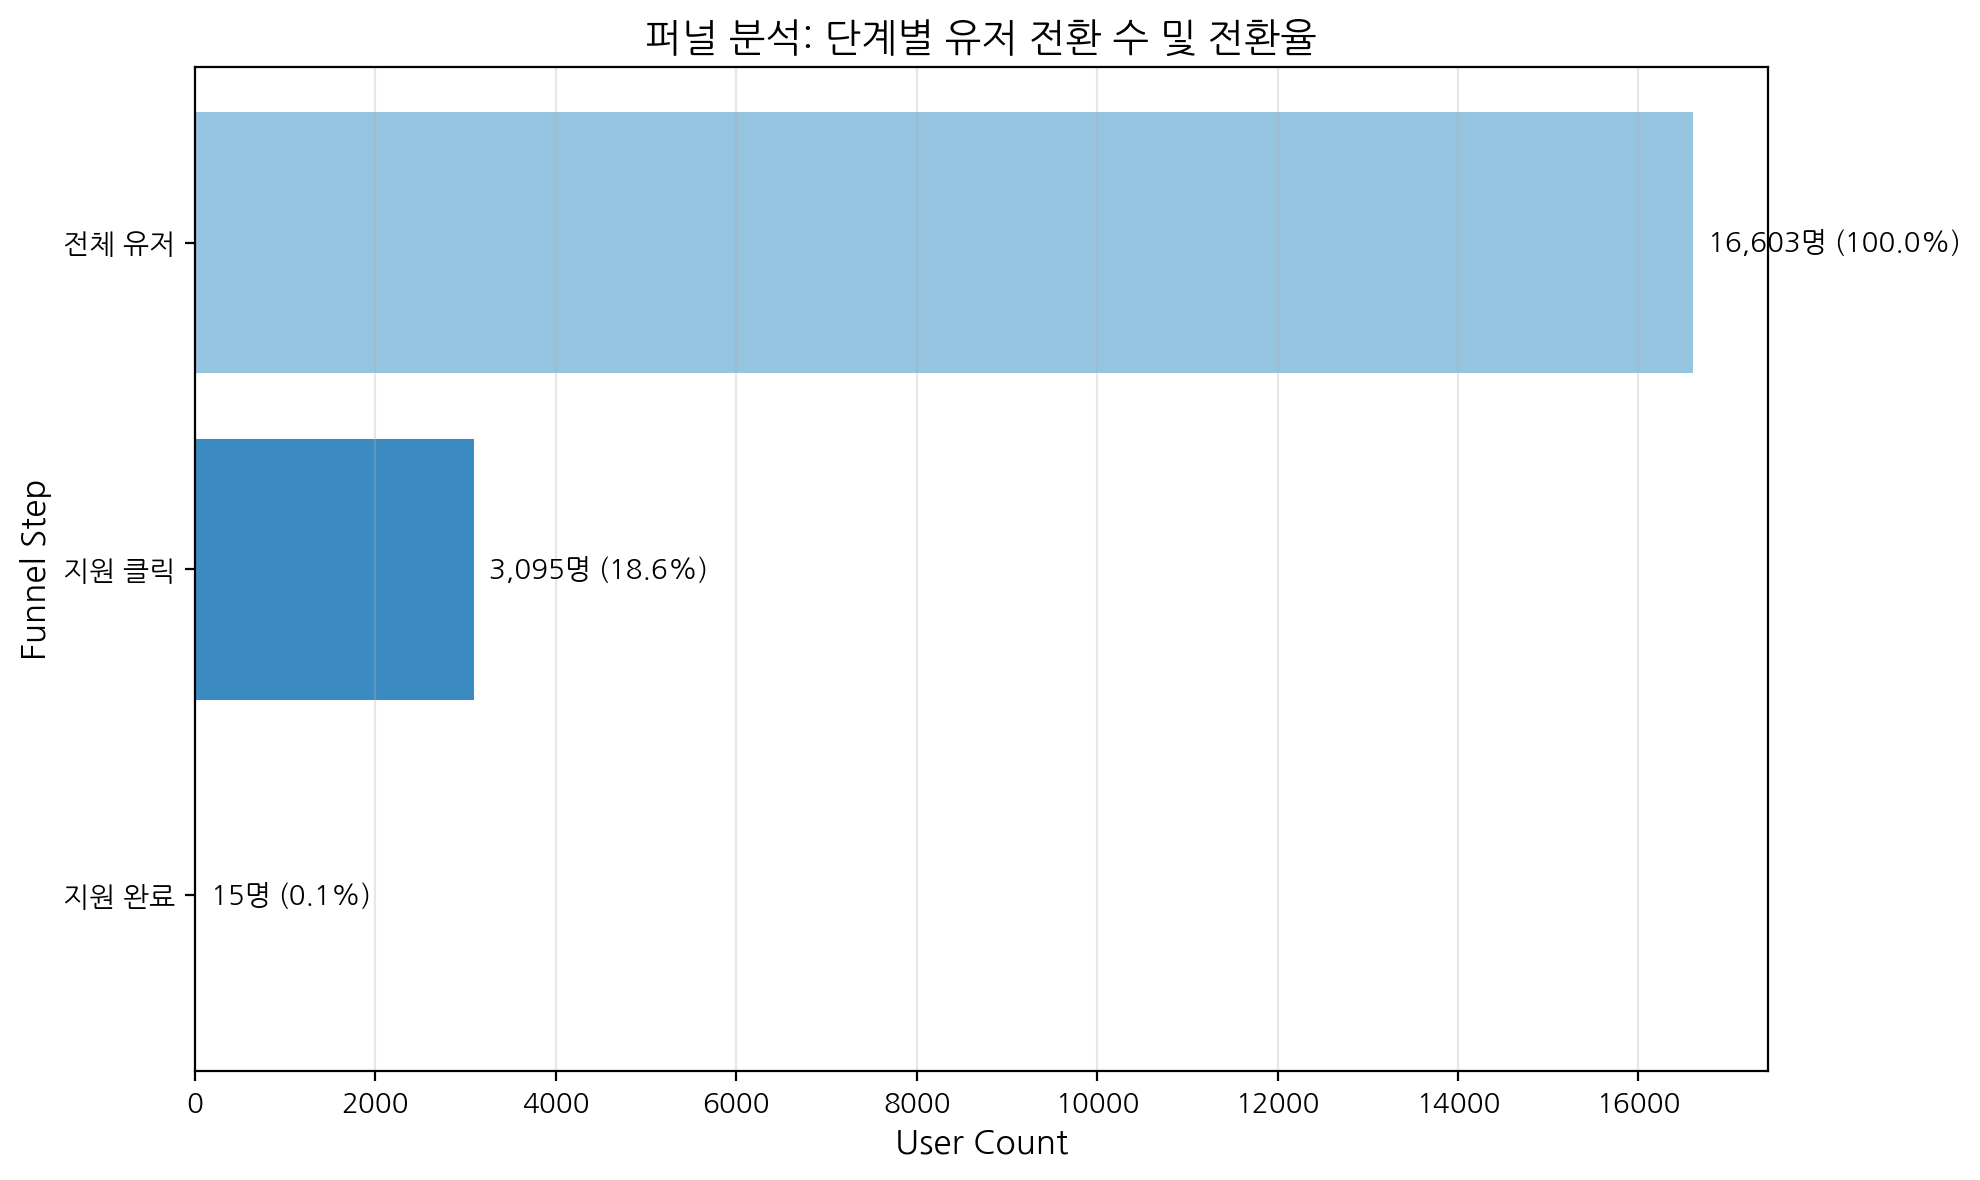

In [235]:
# 데이터 준비
x = funnel_summary['단계']
y = funnel_summary['유저수']
rate = funnel_summary['전환율(모수대비, %)']

colors = cm.Blues(np.linspace(0.4, 0.9, len(y)))

# 그래프 크기 및 스타일 설정
plt.figure(figsize=(10,6))
bars = plt.barh(x[::-1], y[::-1], color=colors[::-1])  # 단계가 위→아래로 진행되게 뒤집기
plt.title('퍼널 분석: 단계별 유저 전환 수 및 전환율', fontsize=14)
plt.xlabel('User Count', fontsize=12)
plt.ylabel('Funnel Step', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# 값 표시 (예: "3,320명 (15.9%)")
for i, (val, pct) in enumerate(zip(y[::-1], rate[::-1])):
    plt.text(val + max(y)*0.01, i, f"{int(val):,}명 ({pct:.1f}%)", 
             va='center', fontsize=10)

plt.tight_layout()
plt.show()


### 가이드를 클릭만 해본 유저의 Funnel

In [203]:
funnel_summary

,단계,유저수,"전환율(모수대비, %)",직전단계→다음단계 전환율(%)
0,전체 유저,12884,100.00,NaN
1,지원 클릭,3095,24.02,24.02
2,지원 완료(클릭 이후),15,0.12,0.48


### 전체 Funnel

In [35]:
# 더 간단하게 action_type 구분
log['action_prefix'] = log['action_type'].str.split(' - ').str[0]

In [36]:
log['action_type'].unique()

array(['etc', 'profile', 'apply-step1', 'apply-step2', 'apply-step3',
       'apply-step4', 'applydone', 'apply-update', 'profile-notify',
       'job-recruit', 'profile-verify', 'companies-view', 'guideclick',
       'signup-click', 'companies-member', 'search', 'apply-progress',
       'signup-done', 'apply-click', 'social', 'profile-setting',
       'job-bookmark', 'companies-bookmark', 'guide-career',
       'guide-specialty', 'guide-language', 'guide-newscard',
       'guide-overview', 'guide-snscard', 'guide-funding'], dtype=object)

In [37]:
log['action_prefix'].unique()

array(['etc', 'profile', 'apply-step1', 'apply-step2', 'apply-step3',
       'apply-step4', 'applydone', 'apply-update', 'profile-notify',
       'job-recruit', 'profile-verify', 'companies-view', 'guideclick',
       'signup-click', 'companies-member', 'search', 'apply-progress',
       'signup-done', 'apply-click', 'social', 'profile-setting',
       'job-bookmark', 'companies-bookmark', 'guide-career',
       'guide-specialty', 'guide-language', 'guide-newscard',
       'guide-overview', 'guide-snscard', 'guide-funding'], dtype=object)

In [38]:
event_pivot = log.pivot_table(
    index='user_uuid',
    columns='action_prefix',
    values='timestamp',  # 또는 'action_type'
    aggfunc='min'        # 이벤트 최초 시각
)

In [39]:
event_pivot.head(30)

action_prefix,apply-click,apply-progress,apply-step1,apply-step2,apply-step3,apply-step4,apply-update,applydone,companies-bookmark,companies-member,...,job-bookmark,job-recruit,profile,profile-notify,profile-setting,profile-verify,search,signup-click,signup-done,social
user_uuid,,,,,,,,,,,,,,,,,,,,,
0002535c-eacb-456b-a620-92c917332ba3,NaT,NaT,2022-10-19 10:31:13.720681,2022-10-19 10:32:20.086824,2022-10-19 10:32:27.430265,2022-10-19 10:35:32.846765,2022-10-19 12:40:50.089136,2022-10-19 10:35:40.794268,NaT,NaT,...,NaT,2023-01-25 17:41:45.353279,2022-10-05 21:48:59.220755,2022-11-14 14:32:34.953150,NaT,NaT,NaT,NaT,NaT,NaT
0005769f-54b1-44ab-b6d3-bd9147c006a8,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,2022-11-07 13:42:24.760892,NaT,NaT,NaT,NaT
000681b4-bb66-4ccf-9786-f0066d13a34e,NaT,2023-12-26 22:42:33.173624,NaT,NaT,NaT,NaT,2023-12-26 22:39:15.919392,NaT,NaT,2023-12-26 22:37:21.241576,...,NaT,2023-12-24 21:08:56.315885,2023-12-24 20:55:43.636086,2023-12-24 20:55:41.566966,NaT,NaT,2023-12-26 22:41:30.057846,2023-12-26 22:35:34.655784,NaT,NaT
000b55ad-5c86-438b-a5b0-9ea3a2917789,2023-07-06 20:12:17.461053,2023-07-06 18:47:52.889904,2023-07-06 20:08:19.447925,2023-07-06 20:08:28.892129,2023-07-07 22:29:25.033016,2023-07-06 20:08:36.265207,2023-06-23 21:22:02.104011,2023-07-06 20:12:16.885235,NaT,NaT,...,NaT,2023-06-21 20:02:15.152688,2023-06-21 20:02:01.742970,2023-07-22 17:13:38.502344,NaT,2023-07-06 18:47:30.988926,2023-06-21 20:02:23.192086,2023-06-21 20:01:34.663903,2023-06-21 20:03:51.737453,NaT
000d53f7-5ddd-48ba-8dab-bb77b157e13a,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,2023-10-20 15:28:17.266307,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
000e8610-16d3-4e9e-bf50-202d191ffac4,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-07-19 13:10:19.475748,...,NaT,2022-11-15 08:50:45.094639,2022-11-15 08:50:29.308130,2022-12-16 15:30:59.040413,NaT,NaT,2022-11-15 08:50:34.094352,2023-07-19 13:07:13.033571,NaT,NaT
0017a738-4fcc-441e-983b-a6033890a9db,NaT,NaT,NaT,2023-12-04 15:37:54.848684,2023-12-04 15:37:55.331559,NaT,2022-11-24 16:26:16.185242,NaT,NaT,2023-08-21 18:53:44.265526,...,NaT,2022-11-24 16:26:55.955821,2022-11-29 16:37:35.262628,2022-12-26 10:14:30.097295,NaT,NaT,2023-01-20 15:37:02.497012,NaT,NaT,2023-01-19 15:17:44.871110
003a83bd-6cb7-4f99-ab3a-66904df762e2,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2022-10-04 00:24:43.318183,...,NaT,2022-10-03 00:51:28.405164,2022-10-03 00:40:49.586000,NaT,NaT,NaT,2022-10-03 01:06:40.202399,NaT,NaT,2022-10-03 00:41:20.446384
00413632-8541-452b-97e6-39bd6ddf641b,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,2022-10-13 09:38:08.789192,2022-10-13 09:38:01.522405,NaT,NaT,NaT,NaT,NaT,NaT


In [40]:
# 예시 단계
steps = ['탐색', '가이드', '지원서 작성', '지원 완료']  # '지원완료'는 아까 rename한 값이 있으면 그걸 써도 됨

funnel_counts = {step: event_pivot[step].notna().sum() for step in steps if step in event_pivot.columns}

funnel_df = pd.DataFrame(list(funnel_counts.items()), columns=['step', 'user_count'])
funnel_df['conversion_rate'] = funnel_df['user_count'] / funnel_df['user_count'].iloc[0]


IndexError: single positional indexer is out-of-bounds

In [ ]:
funnel_df

,step,user_count,conversion_rate
0,탐색,19725,1.000000
1,가이드,4479,0.227072
2,지원서 작성,11410,0.578454
3,지원 완료,10028,0.508390


### 가이드 미사용 유저 Funnel

In [ ]:
not_guide_action_log

not_guide_action_log['action_prefix'] = not_guide_action_log['action_type'].str.split(' - ').str[0]

event_pivot = not_guide_action_log.pivot_table(
    index='user_uuid',
    columns='action_prefix',
    values='timestamp',  # 또는 'action_type'
    aggfunc='min'        # 이벤트 최초 시각
)

In [ ]:
# funnel
steps = ['탐색', '지원서 작성', '지원 완료']  
funnel_counts = {step: event_pivot[step].notna().sum() for step in steps if step in event_pivot.columns}

funnel_df = pd.DataFrame(list(funnel_counts.items()), columns=['step', 'user_count'])
funnel_df['conversion_rate'] = funnel_df['user_count'] / funnel_df['user_count'].iloc[0]

funnel_df

,step,user_count,conversion_rate
0,탐색,15253,1.000000
1,지원서 작성,7478,0.490264
2,지원 완료,6272,0.411198


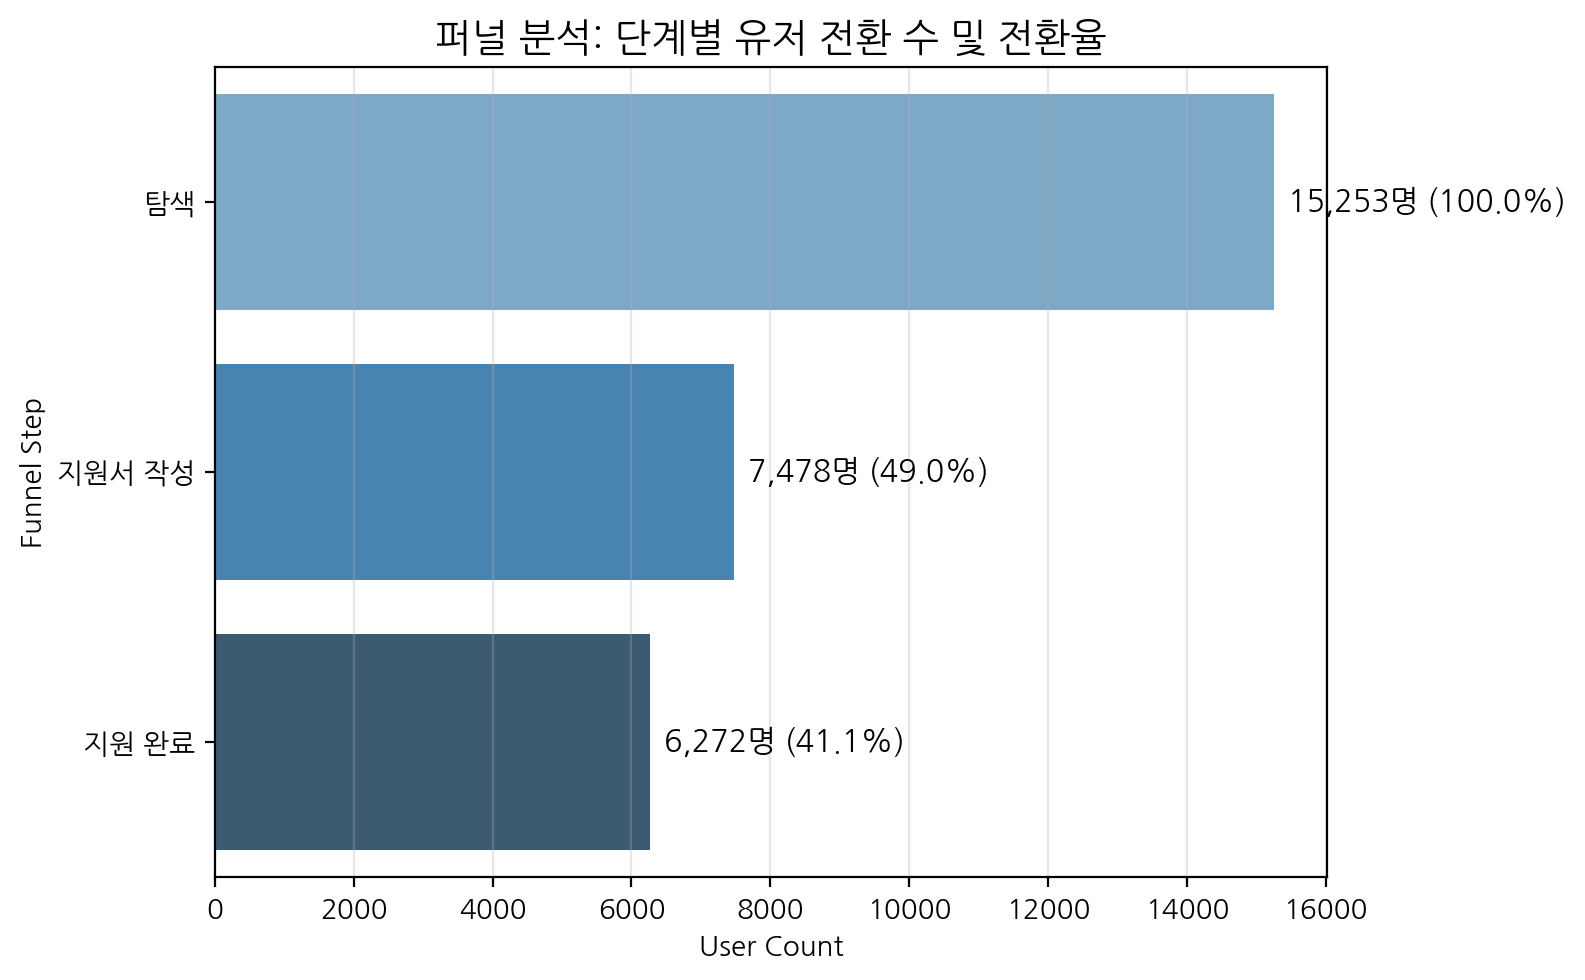

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 순서를 위에서 아래로 자연스럽게 보이게 하기 위해 순서 반전
funnel_df_sorted = funnel_df[::1]

plt.figure(figsize=(8, 5))
sns.barplot(
    data=funnel_df_sorted,
    x='user_count',
    y='step',
    palette='Blues_d'  # 차분한 블루 계열 색상
)

# 레이블 텍스트 추가
for i, row in funnel_df_sorted.iterrows():
    plt.text(
        row['user_count'] + 200,   # 바 끝부분 기준으로 오른쪽
        i,
        f"{row['user_count']:,}명 ({row['conversion_rate']*100:.1f}%)",
        va='center',
        fontsize=11
    )

plt.title('퍼널 분석: 단계별 유저 전환 수 및 전환율', fontsize=14)
plt.xlabel('User Count')
plt.ylabel('Funnel Step')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 가이드 사용 유저 Funnel

In [ ]:
# 가이드 사용 유저 pivot table 생성
guide_action_log

guide_action_log['action_prefix'] = guide_action_log['action_type'].str.split(' - ').str[0]

event_pivot = guide_action_log.pivot_table(
    index='user_uuid',
    columns='action_prefix',
    values='timestamp',  
    aggfunc='min'        
)

In [ ]:
# funnel
steps = ['탐색', '가이드', '지원서 작성', '지원 완료'] 
funnel_counts = {step: event_pivot[step].notna().sum() for step in steps if step in event_pivot.columns}

funnel_df = pd.DataFrame(list(funnel_counts.items()), columns=['step', 'user_count'])
funnel_df['conversion_rate'] = funnel_df['user_count'] / funnel_df['user_count'].iloc[0]

funnel_df

,step,user_count,conversion_rate
0,탐색,4472,1.000000
1,가이드,4479,1.001565
2,지원서 작성,3932,0.879249
3,지원 완료,3756,0.839893


In [ ]:
# 1단계: 탐색을 한 유저
step1 = event_pivot[event_pivot['탐색'].notna()]

# 2단계: 탐색도 하고 가이드도 한 유저
step2 = step1[step1['가이드'].notna()]

# 3단계: 위 + 지원서 작성까지 한 유저
step3 = step2[step2['지원서 작성'].notna()]

# 4단계: 위 + 지원 완료까지 한 유저
step4 = step3[step3['지원 완료'].notna()]

# user 수와 전환율 정리
funnel_counts = {
    '탐색': len(step1),
    '가이드': len(step2),
    '지원서 작성': len(step3),
    '지원 완료': len(step4),
}

funnel_df = pd.DataFrame(list(funnel_counts.items()), columns=['step', 'user_count'])
funnel_df['conversion_rate'] = funnel_df['user_count'] / funnel_df['user_count'].iloc[0]
funnel_df

# 순서를 


,step,user_count,conversion_rate
0,탐색,4472,1.000000
1,가이드,4472,1.000000
2,지원서 작성,3932,0.879249
3,지원 완료,3756,0.839893


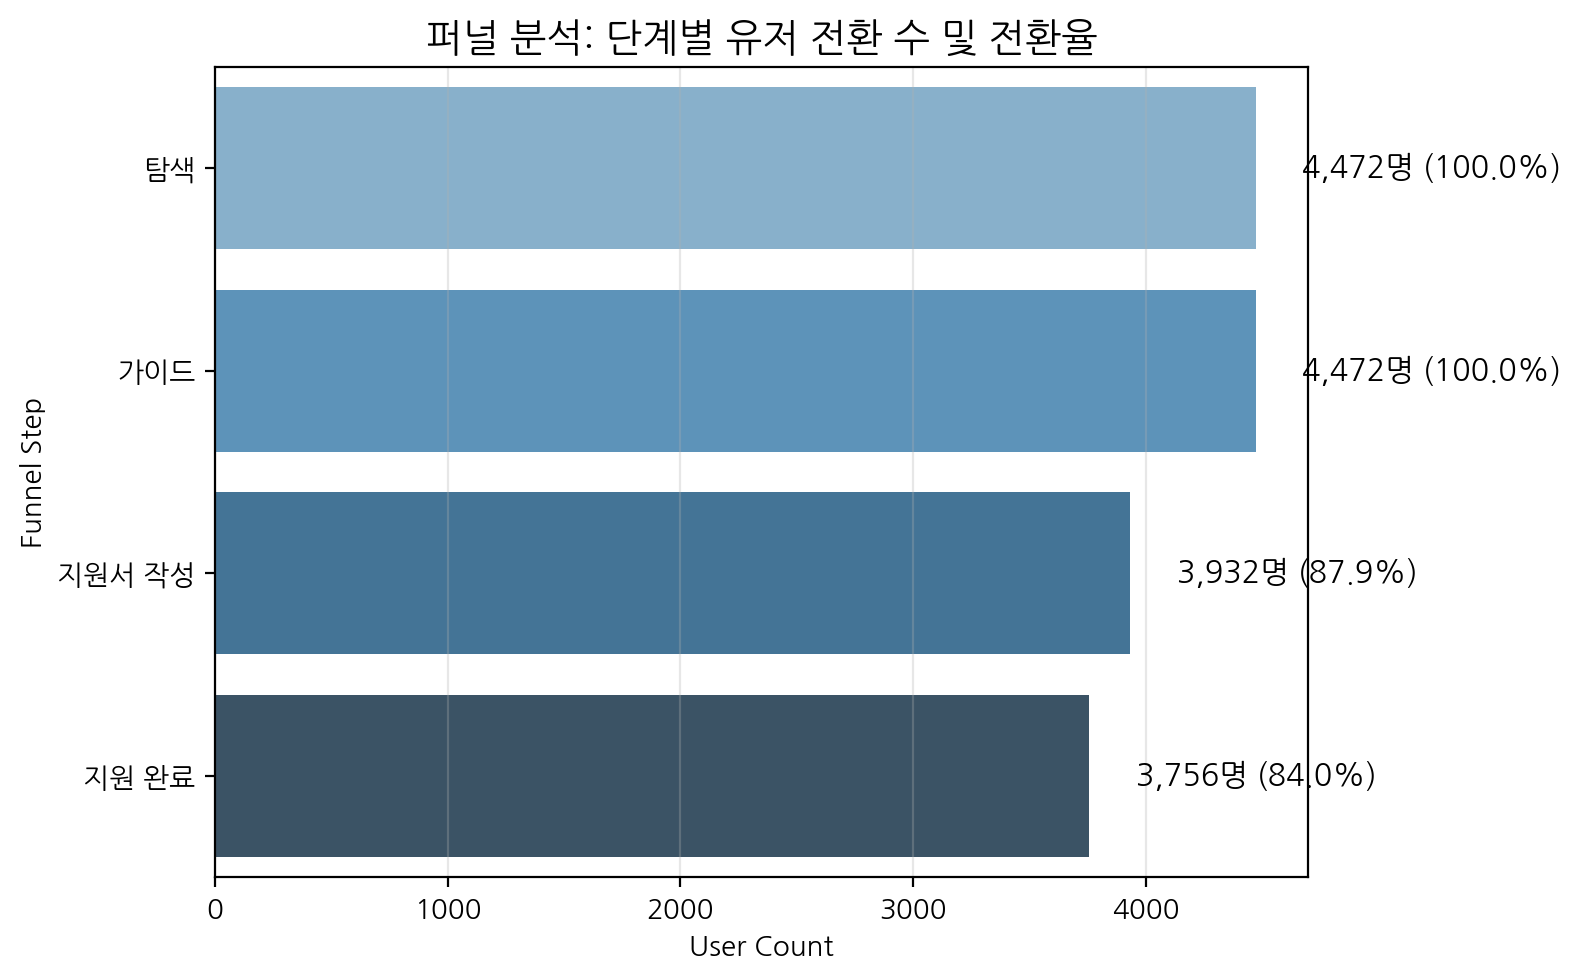

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 순서를 위에서 아래로 자연스럽게 보이게 하기 위해 순서 반전
funnel_df_sorted = funnel_df[::1]

plt.figure(figsize=(8, 5))
sns.barplot(
    data=funnel_df_sorted,
    x='user_count',
    y='step',
    palette='Blues_d'  # 차분한 블루 계열 색상
)

# 레이블 텍스트 추가
for i, row in funnel_df_sorted.iterrows():
    plt.text(
        row['user_count'] + 200,   # 바 끝부분 기준으로 오른쪽
        i,
        f"{row['user_count']:,}명 ({row['conversion_rate']*100:.1f}%)",
        va='center',
        fontsize=11
    )

plt.title('퍼널 분석: 단계별 유저 전환 수 및 전환율', fontsize=14)
plt.xlabel('User Count')
plt.ylabel('Funnel Step')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
log['month'] = log['timestamp'].dt.strftime('%Y-%m')

In [ ]:
log['used_guide'] = log['action_type'].str.contains('가이드', na=False).astype(int)
log['submitted'] = (log['action_type'] == '지원 완료').astype(int)

In [ ]:
user_summary = log.groupby('user_uuid').agg({
    'used_guide': 'max',
    'submitted': 'max',
    'month': 'first'
}).reset_index()

In [ ]:
monthly = user_summary.groupby('month').agg(
    guide_use_rate=('used_guide', 'mean'),
    conversion_rate=('submitted', 'mean'),
    total_users=('user_uuid', 'count')
).reset_index()

### 시간별 전환율 추이

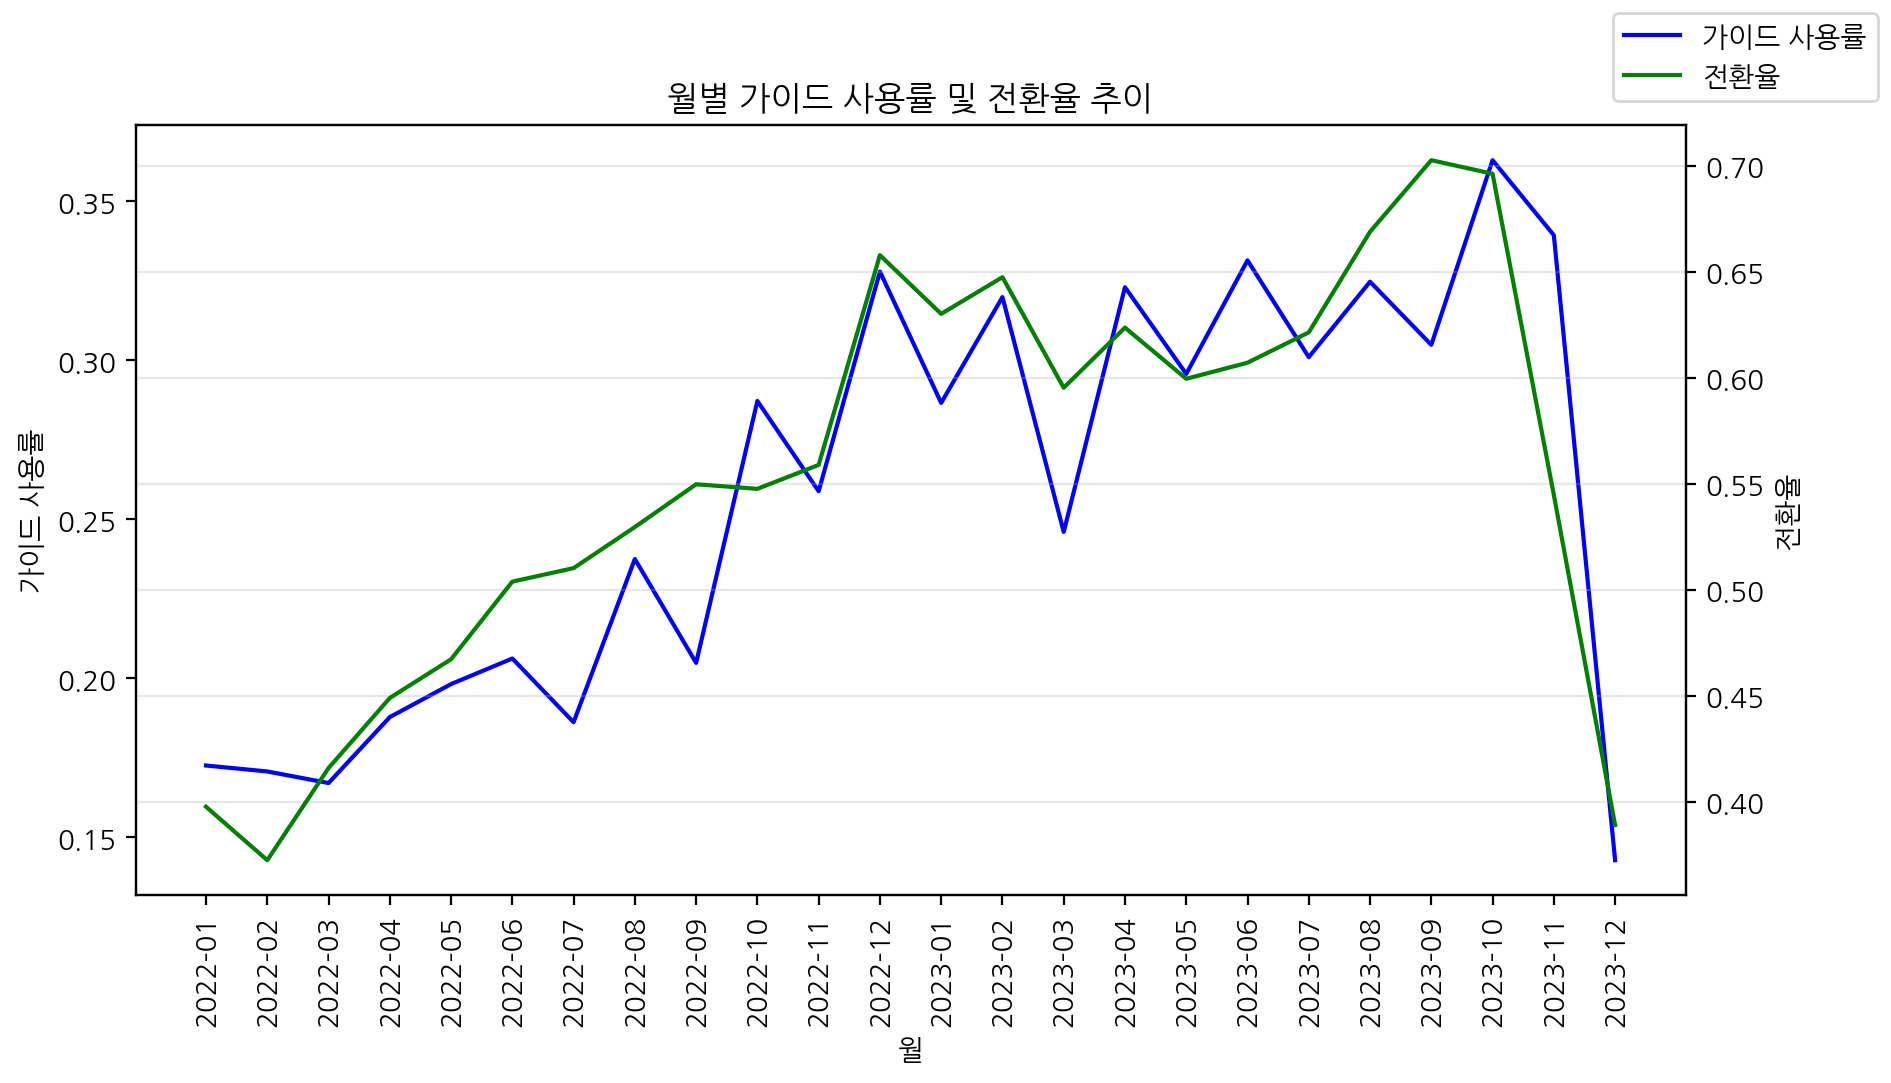

In [ ]:
# 시각화
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

ax2 = ax1.twinx()
ax1.plot(monthly['month'].astype(str), monthly['guide_use_rate'], label='가이드 사용률', color='blue')
ax2.plot(monthly['month'].astype(str), monthly['conversion_rate'], label='전환율', color='green')

ax1.set_ylabel('가이드 사용률')
ax2.set_ylabel('전환율')
ax1.set_xlabel('월')
ax1.tick_params(axis='x', labelrotation=90)
plt.title('월별 가이드 사용률 및 전환율 추이')
fig.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.show()


# 가이드액션 현황

## 미노출 / 노출 / 노출+사용

In [ ]:
log['action_prefix'] = log['action_type'].str.split(' - ').str[0]

In [ ]:
# '클릭' 여부 (1: 클릭, 0: 비클릭)
log['is_click'] = log['action_prefix'].apply(lambda x: 1 if '클릭' in str(x) else 0)

# '가이드' 여부 (1: 가이드 관련, 0: 그 외)
log['is_guide'] = log['action_prefix'].apply(lambda x: 1 if '가이드' in str(x) else 0)

# 유저별로 클릭 여부, 가이드 여부 최대값 추출 (1이 하나라도 있으면 1, 중복 되지 않도록)
user_log_status = log.groupby('user_uuid')[['is_click', 'is_guide']].max().reset_index()
user_log_status

,user_uuid,is_click,is_guide
0,0002535c-eacb-456b-a620-92c917332ba3,0,0
1,0005769f-54b1-44ab-b6d3-bd9147c006a8,0,0
2,000681b4-bb66-4ccf-9786-f0066d13a34e,1,0
3,000b55ad-5c86-438b-a5b0-9ea3a2917789,1,0
4,000d53f7-5ddd-48ba-8dab-bb77b157e13a,0,0
...,...,...,...
21080,fff082bd-c063-4d10-be2d-b2b53f54527e,1,0
21081,fff3440e-7c0a-485b-a392-c41023060e96,1,0
21082,fff45252-3c40-4805-99e9-6b650c1fca80,0,0
21083,fff8a5c0-c85b-4e30-a22d-ed61b4480615,1,0


In [ ]:
def classify_user(row):
    if row['is_click'] == 1 and row['is_guide'] == 1:
        return 2
    elif row['is_click'] == 1 and row['is_guide'] == 0:
        return 1
    else:
        return 0

user_log_status['group'] = user_log_status.apply(classify_user, axis=1)

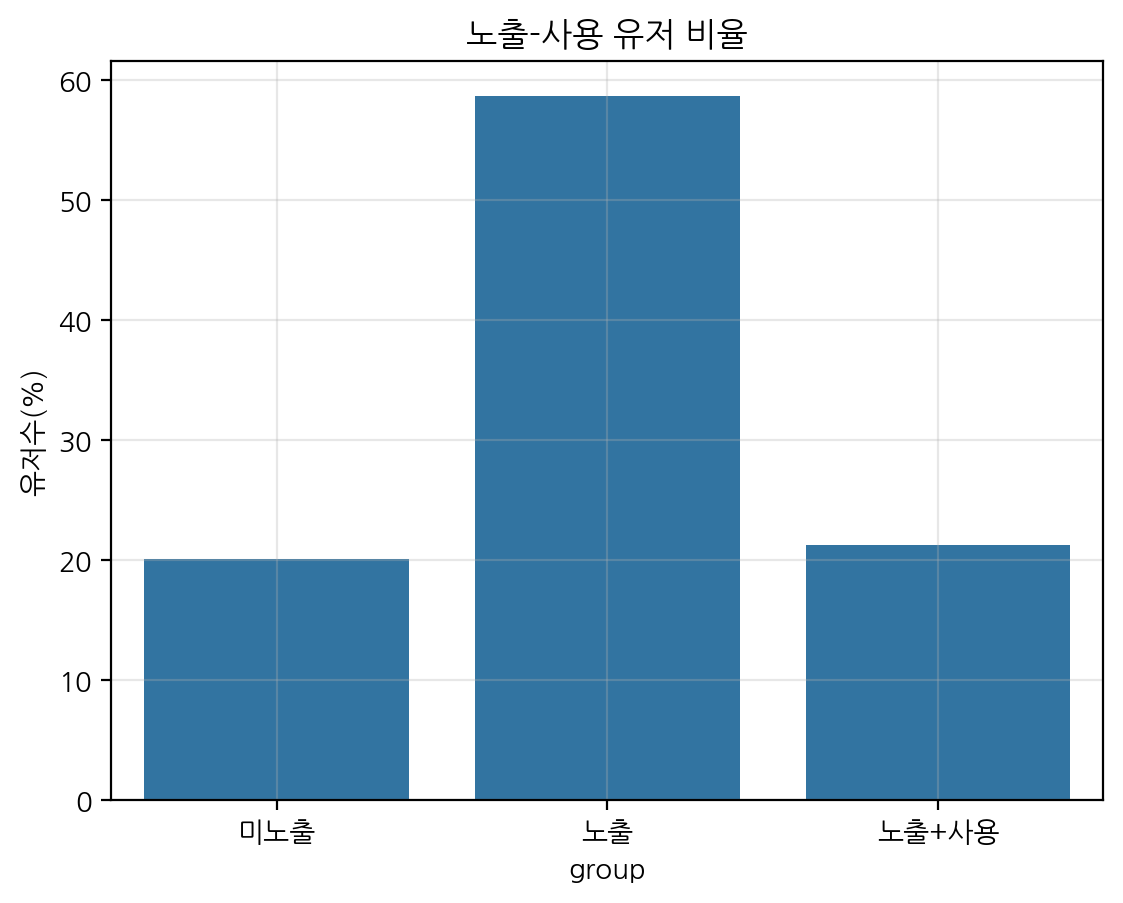

In [ ]:
click_guide = user_log_status.groupby('group')['user_uuid'].count()
click_guide = pd.DataFrame(click_guide).reset_index()  # 보기 편하게 데이터 프레임으로 변경

# 보기 쉽도록 컬럼명 변경
click_guide.rename(columns={ 
    'user_uuid' : 'count'
}, inplace=True)

# 테이블 생성
click_guide['pct'] = round(click_guide['count'] / click_guide['count'].sum() * 100, 2)
click_guide

# 시각화
sns.barplot(data=click_guide, x='group', y='pct')
plt.title('노출-사용 유저 비율')
plt.grid(alpha=0.3)
plt.xticks(ticks=[0, 1, 2], labels=['미노출', '노출', '노출+사용'])
plt.ylabel('유저수(%)')
plt.show()

```
노출도 되지 않은 유저 수 : 4244 (20.13 %)
노출만 된 유저 수 : 12,363  (58.63 %)
노출되고 가이드를 사용한 유저 수 : 4478 (21.24 %)

즉, 총 노출은 79.87% 인데
노출유저수 대비 사용 유저 : 약 34%


```

In [ ]:
click_guide

,group,count,pct
0,0,4244,20.13
1,1,12363,58.63
2,2,4478,21.24


## 가이드액션 진입 경로

In [ ]:
log['prev_action'] = log.groupby('user_uuid')['action_prefix'].shift(-1)

In [ ]:
click_log = log[log['action_prefix'] == '클릭'].copy()
route_click = click_log.groupby('prev_action')['prev_action'].count().reset_index(name='route')

In [ ]:
route_click['pct'] = round(route_click['route']/route_click['route'].sum() * 100, 2)
route_click.sort_values('pct', ascending=False, inplace=True)

In [ ]:
route_click

,prev_action,route,pct
10,프로필,223243,62.74
7,추천 서비스,76241,21.43
1,기타,36138,10.16
9,탐색,11356,3.19
6,지원서 확인,4769,1.34
3,소셜 기능,1936,0.54
0,가이드,1064,0.30
8,클릭,528,0.15
5,지원서 작성,457,0.13
2,빈 URL,33,0.01


```
클릭 직전 위치 프로필 > 추천 서비스 > 기타 > 탐색 > 지원서 확인 > 소셜 기능 ...

프로필과 추천 서비스에서 약 83%의 비율로 대부분의 유입이 이뤄지고 있다.
```

# 유저행동분석

```
가이드 액션 기능의 사용을 유도하기 위해 행동패턴 패턴 파악

노출에 비해 현저히 떨어지는 사용자 수
UX 흐름이나 기능 구조에 뭔가 사용이 가로막힌듯한 양상

Q. 왜 노출된 유저가 사용을 안 했을까?
    가설 1. 진입 위치 적절성
    가설 2. 기능 수 과다
    가설 3. 정보 입력 부담
    가설 4. UI / 기능 사용 설득 부족

```

## 미노출/ 노출 / 노출 사용


In [ ]:
# 가이드 기능 세부사항 action_prefix에 적용
log.loc[log['action_type'].str.startswith('가이드 -'), 'action_prefix'] = log.loc[log['action_type'].str.startswith('가이드 -'), 'action_type']

# 가이드 세부사항까지 나오는 걸 확인
log['action_prefix'].unique()

array(['기타', '프로필', '지원서 작성', '추천 서비스', '탐색', '지원서 확인', '지원 완료', '클릭',
       '회원가입', '소셜 기능', '가이드 - 전문 분야 입력', '가이드 - 언어 입력',
       '가이드 - 뉴스/미디어 입력', '가이드 - 펀딩 입력', '가이드 - 개요 입력', '가이드 - 경력 입력',
       '가이드 - 개인 웹사이트/SNS 입력', '빈 URL'], dtype=object)

In [ ]:
# 유저별 사용 순서 리스트로 묶기
user_paths = log.groupby('user_uuid')['action_prefix'].apply(list).reset_index()


# 가이드 노출(클릭)된 순간부터 보기
def get_actions_after_click_deduped(actions):
    if '클릭' in actions:
        click_index = actions.index('클릭')
        after_click = actions[click_index:]
        return list(dict.fromkeys(after_click))
    else:
        return []

# 적용
user_paths['after_click'] = user_paths['action_prefix'].apply(get_actions_after_click_deduped)

# 필요한 컬럼만 가져오기
user_paths = user_paths[['user_uuid', 'after_click']]


# 유저 타입별로 나누기
# 빈 리스트 : 미노출 유저
# 클릭, 가이드 있는 유저 : 노출 + 사용 유저
# 클릭만 있는 유저 : 노출 유저
def classify_user(after_click):
    if not after_click:  # 빈 리스트
        return '미노출 유저'
    elif any(action.startswith('가이드 -') for action in after_click):
        return '노출 및 사용 유저'
    else:
        return '노출 유저'

user_paths['user_type'] = user_paths['after_click'].apply(classify_user)


In [ ]:
user_paths

,user_uuid,after_click,user_type
0,0002535c-eacb-456b-a620-92c917332ba3,[],미노출 유저
1,0005769f-54b1-44ab-b6d3-bd9147c006a8,[],미노출 유저
2,000681b4-bb66-4ccf-9786-f0066d13a34e,"[클릭, 추천 서비스, 프로필, 기타, 탐색, 회원가입, 지원서 확인]",노출 유저
3,000b55ad-5c86-438b-a5b0-9ea3a2917789,"[클릭, 추천 서비스, 프로필, 지원서 확인, 탐색, 기타, 지원서 작성, 지원 완료]",노출 유저
4,000d53f7-5ddd-48ba-8dab-bb77b157e13a,[],미노출 유저
...,...,...,...
21080,fff082bd-c063-4d10-be2d-b2b53f54527e,"[클릭, 프로필, 기타, 지원서 확인, 탐색]",노출 유저
21081,fff3440e-7c0a-485b-a392-c41023060e96,"[클릭, 프로필, 지원서 확인, 기타, 탐색]",노출 유저
21082,fff45252-3c40-4805-99e9-6b650c1fca80,[],미노출 유저
21083,fff8a5c0-c85b-4e30-a22d-ed61b4480615,"[클릭, 프로필, 탐색, 기타, 지원서 확인, 지원서 작성, 추천 서비스]",노출 유저


In [ ]:
# 노출 유저 paths (노출, 기능사용X)
exposed_paths = user_paths[user_paths['user_type'] == '노출 유저'][['user_uuid', 'after_click']]

# 노출 및 사용 유저 paths (노출, 기능사용O)
exposed_used_paths = user_paths[user_paths['user_type'] == '노출 및 사용 유저'][['user_uuid', 'after_click']]

### 유저그룹별 행동량

In [ ]:
# 노출 유저의 행동 특성 분석
exposed_paths['action_length'] = exposed_paths['after_click'].apply(len)
exposed_paths['action_length'].describe()

count    12368.000000
mean         6.683053
std          2.080408
min          1.000000
25%          5.000000
50%          7.000000
75%          8.000000
max         11.000000
Name: action_length, dtype: float64

In [ ]:
# 노출 후 기능 사용한 유저의 행동 특성 분석
exposed_used_paths['action_length'] = exposed_used_paths['after_click'].apply(len)
exposed_used_paths['action_length'].describe()

count    4473.000000
mean       12.041359
std         2.551936
min         4.000000
25%        10.000000
50%        12.000000
75%        14.000000
max        18.000000
Name: action_length, dtype: float64

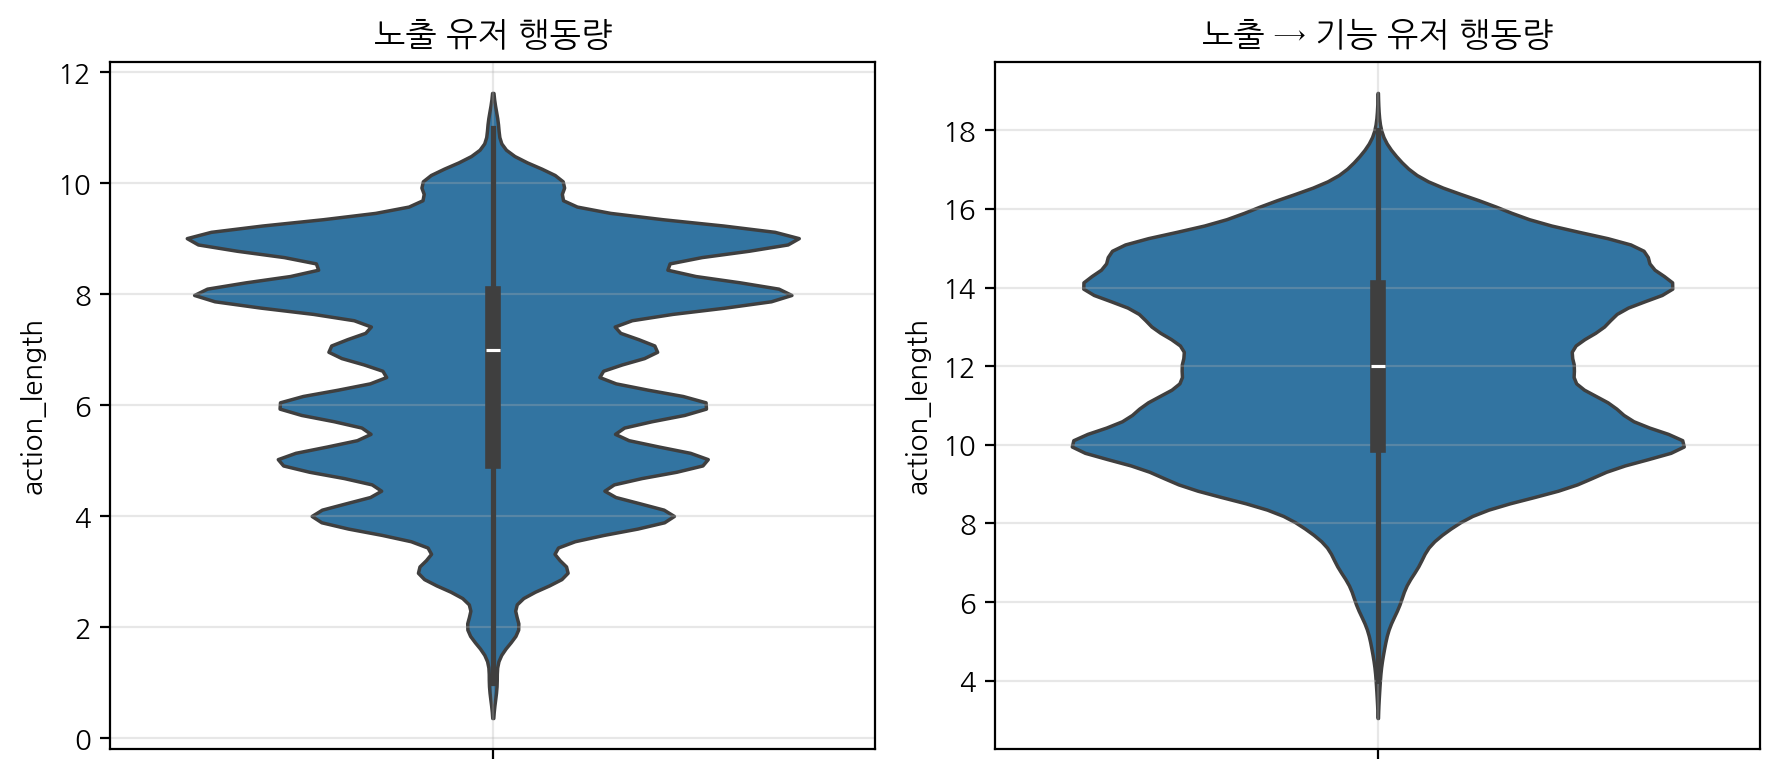

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

sns.violinplot(data=exposed_paths, y='action_length', ax=ax[0])
ax[0].set_title('노출 유저 행동량')
ax[0].grid(alpha=0.3)

sns.violinplot(data=exposed_used_paths, y='action_length', ax=ax[1])
ax[1].set_title('노출 → 기능 유저 행동량')
ax[1].grid(alpha=0.3)


plt.tight_layout()
plt.show()

### 기능 사용 순서

In [ ]:
# 클릭, 가이드 액션, 지원 완료만 보기
def filter_actions(actions):
    keep = []
    for act in actions:
        if act == '클릭':
            keep.append(act)
        elif act.startswith('가이드 -'):
            keep.append(act)
        elif act in ['지원 완료']:
            keep.append(act)
    return keep

exposed_used_paths['filtered_after_click'] = exposed_used_paths['after_click'].apply(filter_actions)


In [ ]:
exposed_used_paths = exposed_used_paths[['user_uuid', 'filtered_after_click']]

In [ ]:
# 리스트 풀기
exploded = exposed_used_paths.explode('filtered_after_click')

# 유저별 기능 사용 순서매기기(step 컬럼 추가)
exploded['step'] = exploded.groupby('user_uuid').cumcount() + 1

### 기능 사용 개수 분포

In [ ]:
exploded.groupby('step')['user_uuid'].count().reset_index(name='count')

,step,count
0,1,4473
1,2,4473
2,3,4175
3,4,3109
4,5,2606
5,6,2194
6,7,1706
7,8,1045
8,9,292


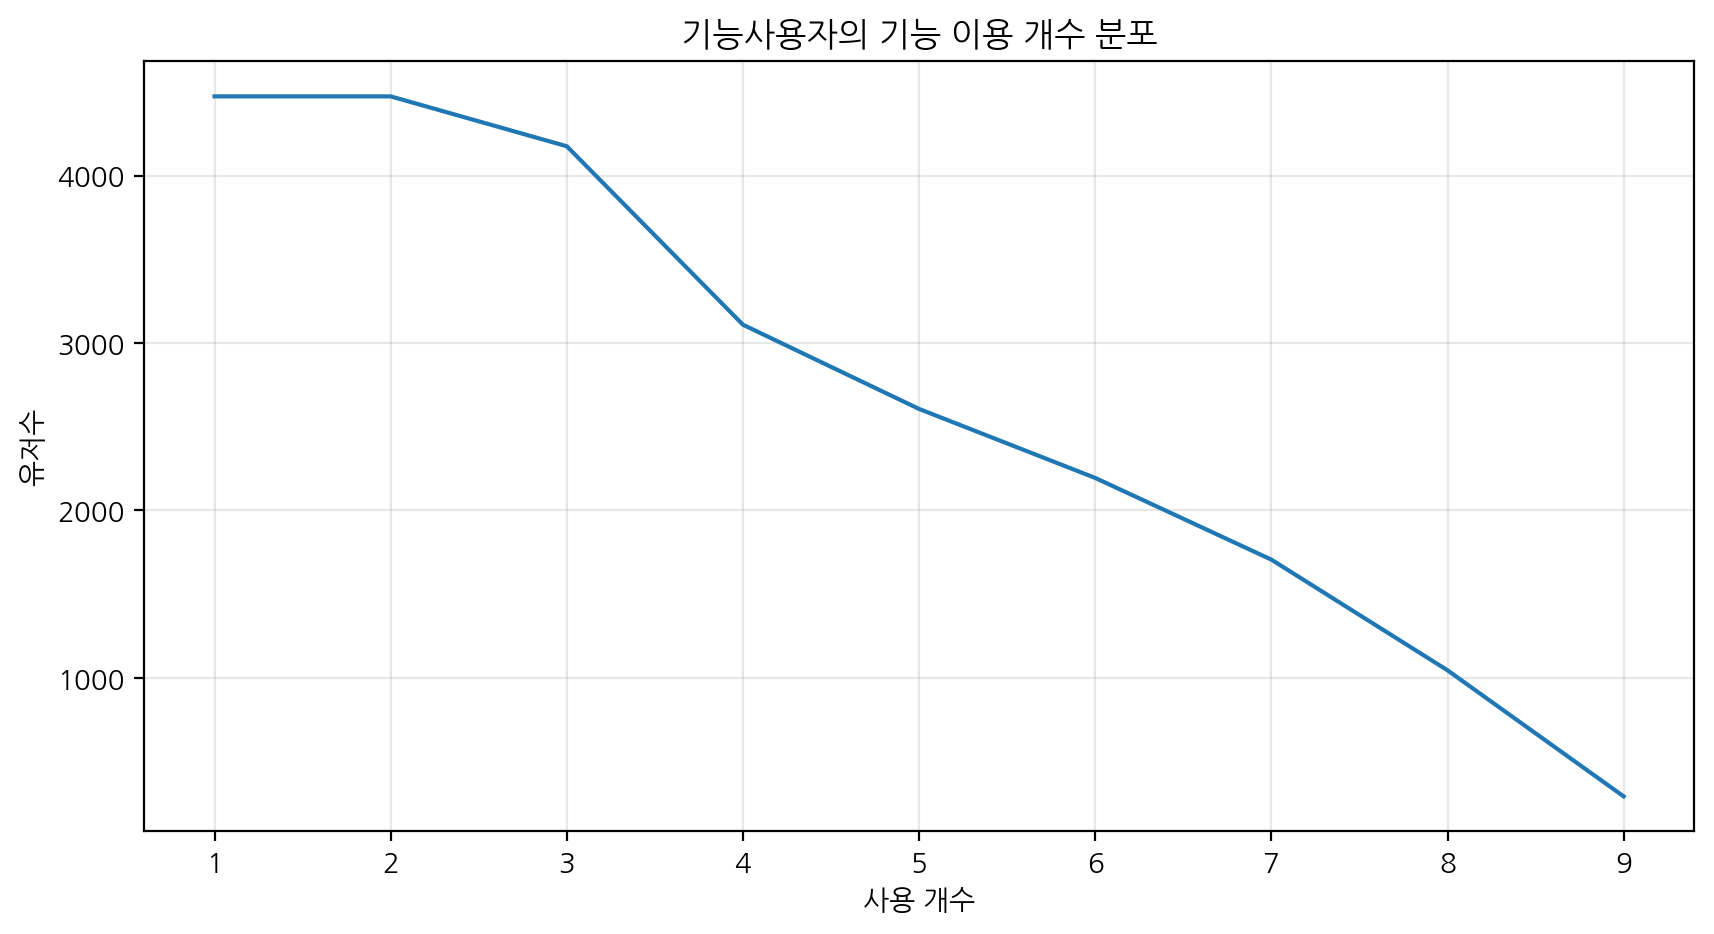

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=exploded.groupby('step')['user_uuid'].count().reset_index(name='count'), x='step', y='count')
plt.grid(alpha=0.3)
plt.title('기능사용자의 기능 이용 개수 분포')
plt.ylabel('유저수')
plt.xlabel('사용 개수')
plt.show()

```
+ 유저 기능 개수에 따라 전환율 차이를 분석해보자
클릭 > 기능 > 지원완료 (전환)
클릭 > 기능 > 미지원 (이탈)
```

### 기능 개수에 따른 전환율

In [ ]:
# 지원완료 이후에도 가이드 기능 이용 로그가 남아있음
# 전환, 이탈 분석을 위해 위와 같은 상황은 제거하여야함

# 지원 완료 step 구하여 컬럼 추가
apply_step = exploded[exploded['filtered_after_click'] == '지원 완료'].groupby('user_uuid')['step'].min().reset_index()
apply_step.rename(columns={'step': 'apply_step'}, inplace=True)

# 병합(컬럼 추가를 위해)
exploded = pd.merge(exploded, apply_step, on='user_uuid', how='inner')

In [ ]:
# 구한 지원 완료 step보다 큰 step은 제거함 (지원완료 이후 가이드 기능 이력 제거)
condition = exploded['step'] > exploded['apply_step']
filtered_exploded = exploded[~condition]

# 컬럼 정리
filtered_exploded = filtered_exploded[['user_uuid', 'filtered_after_click', 'step']]

In [ ]:
filtered_exploded

,user_uuid,filtered_after_click,step
0,003a83bd-6cb7-4f99-ab3a-66904df762e2,클릭,1
1,003a83bd-6cb7-4f99-ab3a-66904df762e2,가이드 - 개요 입력,2
2,003a83bd-6cb7-4f99-ab3a-66904df762e2,가이드 - 경력 입력,3
3,003a83bd-6cb7-4f99-ab3a-66904df762e2,지원 완료,4
4,00605090-bd12-4978-884b-c74e093b40d0,클릭,1
...,...,...,...
21262,ffe6aee0-85cc-45e2-aa5e-129751dff08e,가이드 - 개인 웹사이트/SNS 입력,3
21263,ffe6aee0-85cc-45e2-aa5e-129751dff08e,가이드 - 전문 분야 입력,4
21264,ffe6aee0-85cc-45e2-aa5e-129751dff08e,가이드 - 언어 입력,5
21265,ffe6aee0-85cc-45e2-aa5e-129751dff08e,가이드 - 뉴스/미디어 입력,6


In [ ]:
# 이제 기능 순서에 따른 전환율을 봐보자..
# 지원완료 step별 count
filtered_exploded_apply = filtered_exploded[filtered_exploded['filtered_after_click'] == '지원 완료']
filtered_exploded_apply_count = filtered_exploded_apply.groupby('step')['user_uuid'].count().reset_index(name='apply_count')

# step별 유저 수
filtered_exploded_user_count = filtered_exploded.groupby('step')['user_uuid'].count().reset_index(name='user_count')

# filtered_exploded_user_count의 step1은 진입이므로 삭제 (filtered_exploded_apply엔 step1이 없다.)
filtered_exploded_user_count = filtered_exploded_user_count[filtered_exploded_user_count['step'] >= 2]

# 병합
exploded_step_count = pd.merge(filtered_exploded_user_count, filtered_exploded_apply_count, how='inner', on='step')

In [ ]:
# 특정 스텝에서 전환한 유저가 전체 전환자 중 차지하는 비율
exploded_step_count['pct'] = round(exploded_step_count['apply_count'] / exploded_step_count['apply_count'].sum() * 100, 2)

In [ ]:
# 진입경로 때문에 step이 1씩 늘어남 (그러므로 -1)
exploded_step_count['step'] = exploded_step_count['step'] - 1

In [ ]:
exploded_step_count

,step,user_count,apply_count,pct
0,1,3681,670,18.20
1,2,3011,785,21.33
2,3,2226,278,7.55
3,4,1948,206,5.60
4,5,1742,310,8.42
5,6,1432,494,13.42
6,7,938,660,17.93
7,8,278,278,7.55


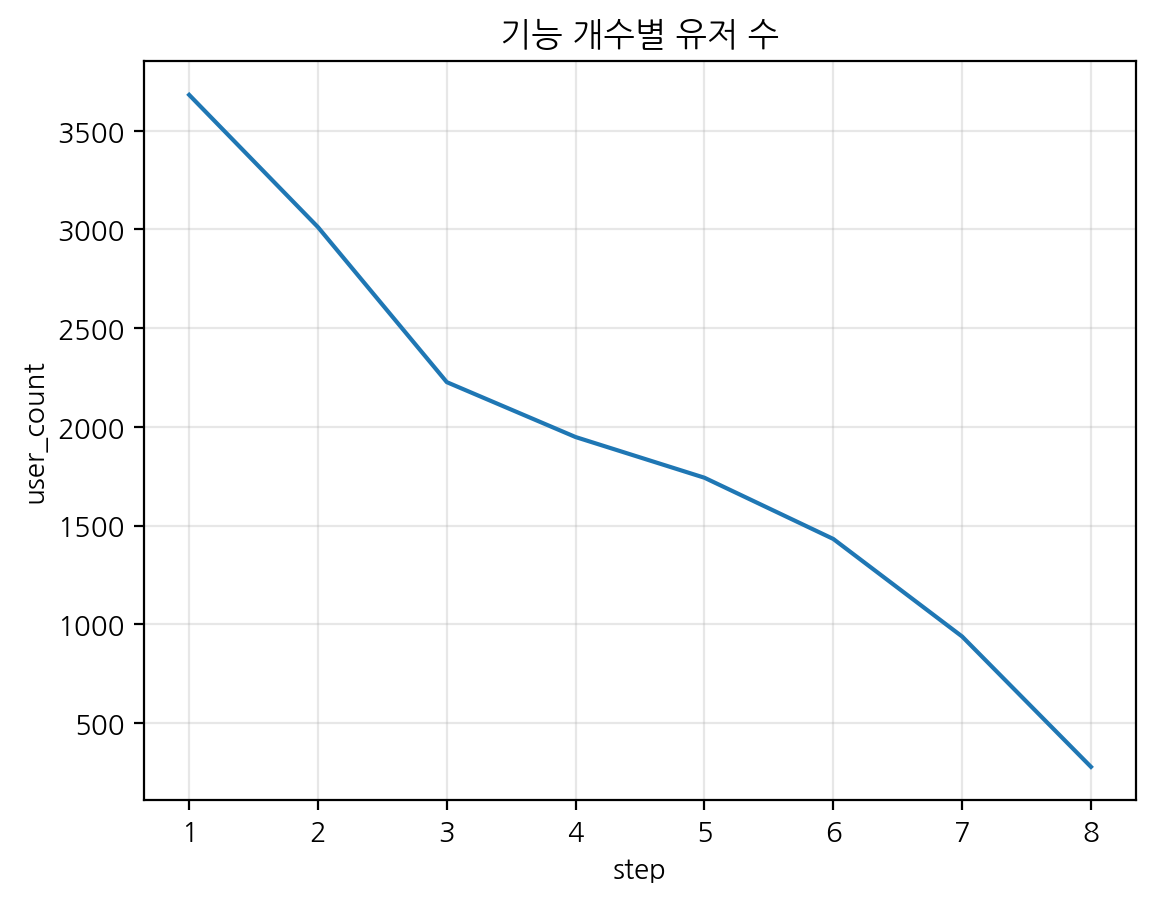

In [ ]:
sns.lineplot(data=exploded_step_count, x='step', y='user_count')
plt.title('기능 개수별 유저 수')
plt.grid(alpha=0.3)
plt.show()

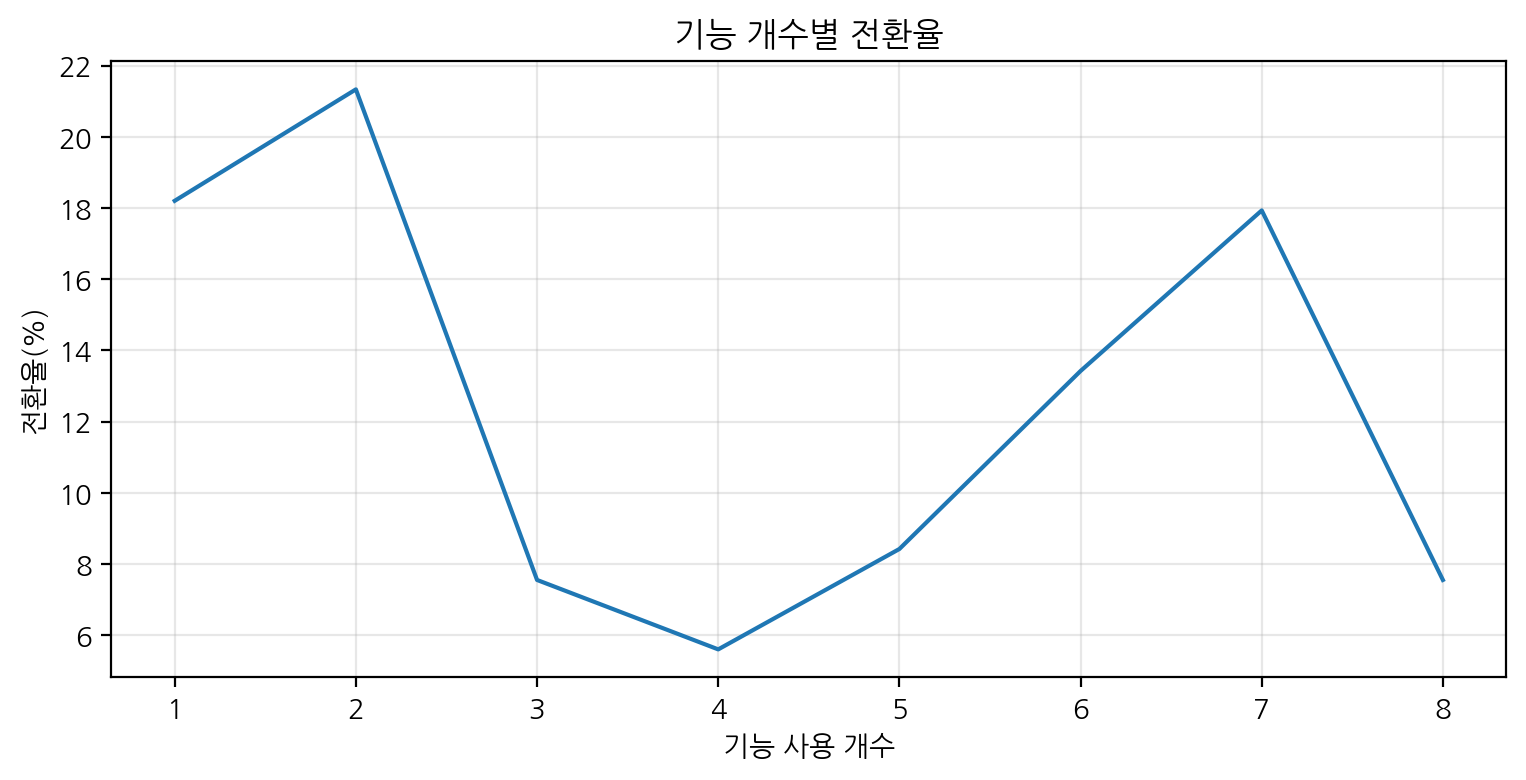

In [ ]:
plt.figure(figsize=(9, 4))
sns.lineplot(data=exploded_step_count, x='step', y='pct')
plt.title('기능 개수별 전환율')
plt.grid(alpha=0.3)
plt.ylabel('전환율(%)')
plt.xlabel('기능 사용 개수')
plt.show()

In [ ]:
filtered_explodedfiltered_exploded_apply_user = filtered_exploded[filtered_exploded['filtered_after_click'] == '지원 완료']['user_uuid'].unique()
new_filtered_exploded = filtered_exploded[filtered_exploded['user_uuid'].isin(filtered_exploded_apply_user)]

NameError: name 'filtered_exploded_apply_user' is not defined

In [ ]:
new_filtered_exploded

,user_uuid,filtered_after_click,step
0,003a83bd-6cb7-4f99-ab3a-66904df762e2,클릭,1
1,003a83bd-6cb7-4f99-ab3a-66904df762e2,가이드 - 개요 입력,2
2,003a83bd-6cb7-4f99-ab3a-66904df762e2,가이드 - 경력 입력,3
3,003a83bd-6cb7-4f99-ab3a-66904df762e2,지원 완료,4
4,00605090-bd12-4978-884b-c74e093b40d0,클릭,1
...,...,...,...
21262,ffe6aee0-85cc-45e2-aa5e-129751dff08e,가이드 - 개인 웹사이트/SNS 입력,3
21263,ffe6aee0-85cc-45e2-aa5e-129751dff08e,가이드 - 전문 분야 입력,4
21264,ffe6aee0-85cc-45e2-aa5e-129751dff08e,가이드 - 언어 입력,5
21265,ffe6aee0-85cc-45e2-aa5e-129751dff08e,가이드 - 뉴스/미디어 입력,6


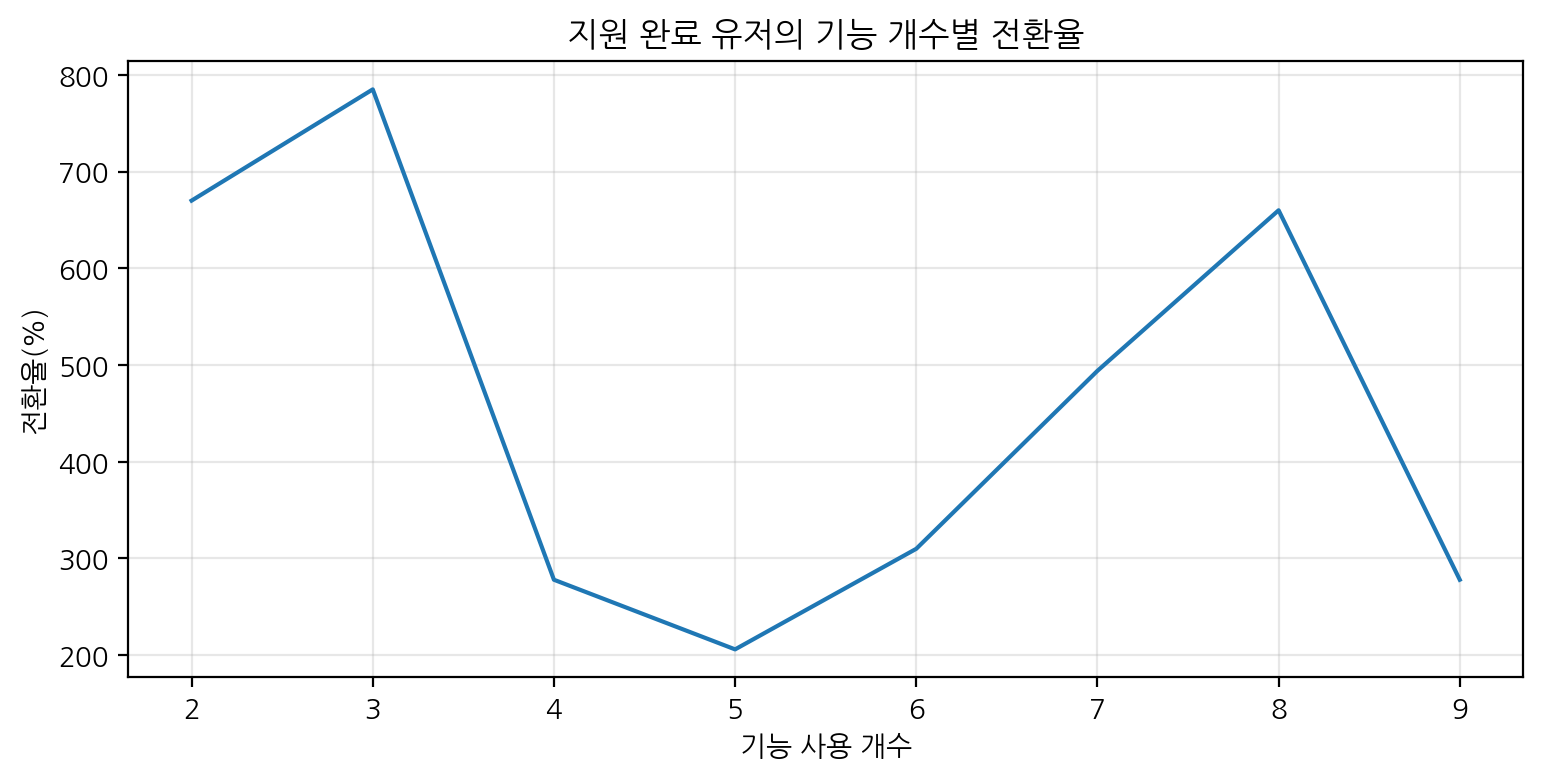

In [ ]:
# 지원 완료한 유저의 기능 사용 개수 (유저별)
new_filtered_exploded_step = new_filtered_exploded.groupby('user_uuid')['step'].max().reset_index(name='max_step')

plt.figure(figsize=(9, 4))
sns.lineplot(data = new_filtered_exploded_step.groupby('max_step')['user_uuid'].count().reset_index(), x='max_step', y='user_uuid')
plt.title('지원 완료 유저의 기능 개수별 전환율')
plt.grid(alpha=0.3)
plt.ylabel('전환율(%)')
plt.xlabel('기능 사용 개수')
plt.show()

### 순서별 기능 사용 빈도 (우선배치, 후순위 배치)

In [ ]:
exploded

,user_uuid,filtered_after_click,step,apply_step
0,003a83bd-6cb7-4f99-ab3a-66904df762e2,클릭,1,4
1,003a83bd-6cb7-4f99-ab3a-66904df762e2,가이드 - 개요 입력,2,4
2,003a83bd-6cb7-4f99-ab3a-66904df762e2,가이드 - 경력 입력,3,4
3,003a83bd-6cb7-4f99-ab3a-66904df762e2,지원 완료,4,4
4,00605090-bd12-4978-884b-c74e093b40d0,클릭,1,2
...,...,...,...,...
21262,ffe6aee0-85cc-45e2-aa5e-129751dff08e,가이드 - 개인 웹사이트/SNS 입력,3,7
21263,ffe6aee0-85cc-45e2-aa5e-129751dff08e,가이드 - 전문 분야 입력,4,7
21264,ffe6aee0-85cc-45e2-aa5e-129751dff08e,가이드 - 언어 입력,5,7
21265,ffe6aee0-85cc-45e2-aa5e-129751dff08e,가이드 - 뉴스/미디어 입력,6,7


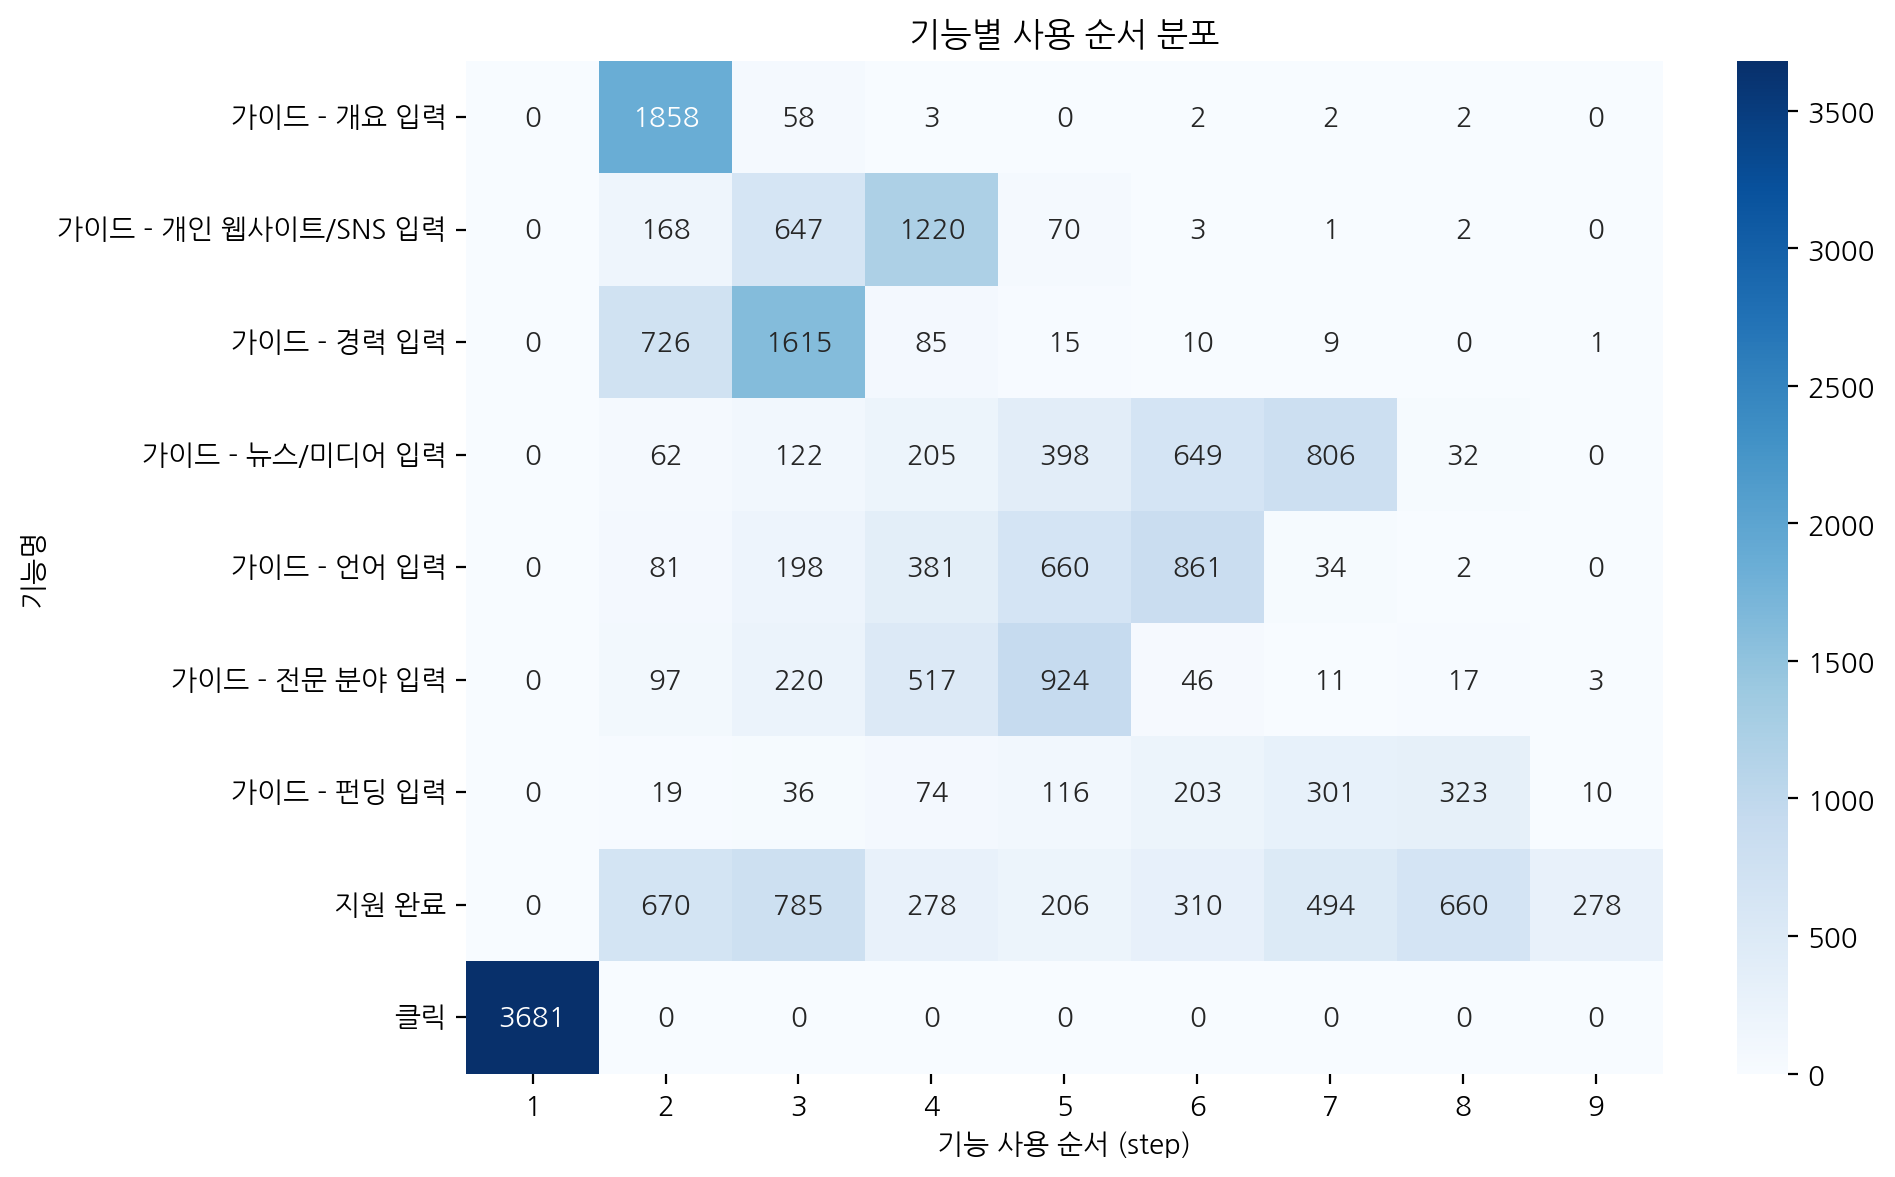

In [ ]:
# 순서별 기능 사용 빈도 테이블 만들기
step_distribution = exploded.groupby(['step', 'filtered_after_click']).size().unstack(fill_value=0)

# 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(step_distribution.T, annot=True, fmt='d', cmap='Blues')
plt.title('기능별 사용 순서 분포')
plt.xlabel('기능 사용 순서 (step)')
plt.ylabel('기능명')
plt.tight_layout()
plt.show()

```
1. 초기 진입
    개요 > 경력 > 전문
(UX상 초기에 보여지는 기능일수록 유저가 많이 진입함)

2. 개요, SNS, 경력 → 우선배치

3. 미디어, 언어, 전문, 펀딩 → 후순위 배치
```

### 장바구니 분석

```
장바구니 분석을 통해
기능을 분류해보자
```

In [ ]:
!pip install mlxtend

In [ ]:
basket_df = filtered_exploded.groupby('user_uuid')['filtered_after_click'].apply(list).reset_index(name='paths')
basket_df

,user_uuid,paths
0,003a83bd-6cb7-4f99-ab3a-66904df762e2,"[클릭, 가이드 - 개요 입력, 가이드 - 경력 입력, 지원 완료]"
1,00605090-bd12-4978-884b-c74e093b40d0,"[클릭, 지원 완료]"
2,008314c3-4837-40fc-be5a-b38d1072db30,"[클릭, 가이드 - 개요 입력, 가이드 - 경력 입력, 지원 완료]"
3,00b43208-7cc2-4a35-b8fb-73baa3258dcf,"[클릭, 가이드 - 개요 입력, 가이드 - 경력 입력, 가이드 - 개인 웹사이트/S..."
4,00bcd13a-391c-4745-8b7e-e24517e91c1d,"[클릭, 가이드 - 개요 입력, 가이드 - 경력 입력, 지원 완료]"
...,...,...
3676,ffa28b75-c592-41ce-abc1-b2d500785939,"[클릭, 가이드 - 뉴스/미디어 입력, 가이드 - 개인 웹사이트/SNS 입력, 가이..."
3677,ffba7f3a-64f6-424d-9e31-3d82242162b1,"[클릭, 가이드 - 개요 입력, 가이드 - 경력 입력, 가이드 - 개인 웹사이트/S..."
3678,ffbcbc12-a9f9-4605-83b4-b5d8af393533,"[클릭, 가이드 - 개요 입력, 가이드 - 경력 입력, 가이드 - 개인 웹사이트/S..."
3679,ffe429f9-200e-472d-9d72-2742727c8ea8,"[클릭, 지원 완료]"


In [ ]:
# TransctionEncoder를 통해 Encoding 해줌
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_result = te.fit_transform(basket_df['paths'])


In [ ]:
# DataFrame에 담아 확인
te_df = pd.DataFrame(te_result, columns=te.columns_)
te_df.head()

,가이드 - 개요 입력,가이드 - 개인 웹사이트/SNS 입력,가이드 - 경력 입력,가이드 - 뉴스/미디어 입력,가이드 - 언어 입력,가이드 - 전문 분야 입력,가이드 - 펀딩 입력,지원 완료,클릭
0,True,False,True,False,False,False,False,True,True
1,False,False,False,False,False,False,False,True,True
2,True,False,True,False,False,False,False,True,True
3,True,True,True,False,False,False,False,True,True
4,True,False,True,False,False,False,False,True,True


In [ ]:
# 장바구니 분석 모델 사용
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(te_df, min_support=0.5, use_colnames=True)  # 최소 지지도 0.5
frequent_itemsets

,support,itemsets
0,0.507742,(가이드 - 개요 입력)
1,0.542787,(가이드 - 경력 입력)
2,1.000000,(지원 완료)
3,1.000000,(클릭)
4,0.507742,"(가이드 - 개요 입력, 지원 완료)"
5,0.507742,"(가이드 - 개요 입력, 클릭)"
6,0.542787,"(가이드 - 경력 입력, 지원 완료)"
7,0.542787,"(가이드 - 경력 입력, 클릭)"
8,1.000000,"(지원 완료, 클릭)"
9,0.507742,"(가이드 - 개요 입력, 지원 완료, 클릭)"


In [ ]:
from mlxtend.frequent_patterns import association_rules

association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)  # 최소 신뢰도 0.6

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(가이드 - 개요 입력),(지원 완료),0.507742,1.000000,0.507742,1.000000,1.0,1.0,0.0,inf,0.0,0.507742,0.0,0.753871
1,(지원 완료),(가이드 - 개요 입력),1.000000,0.507742,0.507742,0.507742,1.0,1.0,0.0,1.0,0.0,0.507742,0.0,0.753871
2,(가이드 - 개요 입력),(클릭),0.507742,1.000000,0.507742,1.000000,1.0,1.0,0.0,inf,0.0,0.507742,0.0,0.753871
3,(클릭),(가이드 - 개요 입력),1.000000,0.507742,0.507742,0.507742,1.0,1.0,0.0,1.0,0.0,0.507742,0.0,0.753871
4,(가이드 - 경력 입력),(지원 완료),0.542787,1.000000,0.542787,1.000000,1.0,1.0,0.0,inf,0.0,0.542787,0.0,0.771394
5,(지원 완료),(가이드 - 경력 입력),1.000000,0.542787,0.542787,0.542787,1.0,1.0,0.0,1.0,0.0,0.542787,0.0,0.771394
6,(가이드 - 경력 입력),(클릭),0.542787,1.000000,0.542787,1.000000,1.0,1.0,0.0,inf,0.0,0.542787,0.0,0.771394
7,(클릭),(가이드 - 경력 입력),1.000000,0.542787,0.542787,0.542787,1.0,1.0,0.0,1.0,0.0,0.542787,0.0,0.771394
8,(지원 완료),(클릭),1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.0,inf,0.0,1.000000,0.0,1.000000
9,(클릭),(지원 완료),1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.0,inf,0.0,1.000000,0.0,1.000000


In [ ]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)
rules.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(가이드 - 개요 입력),(지원 완료),0.507742,1.000000,0.507742,1.000000,1.0,1.0,0.0,inf,0.0,0.507742,0.0,0.753871
1,(지원 완료),(가이드 - 개요 입력),1.000000,0.507742,0.507742,0.507742,1.0,1.0,0.0,1.0,0.0,0.507742,0.0,0.753871
20,(지원 완료),"(가이드 - 경력 입력, 클릭)",1.000000,0.542787,0.542787,0.542787,1.0,1.0,0.0,1.0,0.0,0.542787,0.0,0.771394
19,(가이드 - 경력 입력),"(지원 완료, 클릭)",0.542787,1.000000,0.542787,1.000000,1.0,1.0,0.0,inf,0.0,0.542787,0.0,0.771394
18,"(지원 완료, 클릭)",(가이드 - 경력 입력),1.000000,0.542787,0.542787,0.542787,1.0,1.0,0.0,1.0,0.0,0.542787,0.0,0.771394
17,"(가이드 - 경력 입력, 클릭)",(지원 완료),0.542787,1.000000,0.542787,1.000000,1.0,1.0,0.0,inf,0.0,0.542787,0.0,0.771394
16,"(가이드 - 경력 입력, 지원 완료)",(클릭),0.542787,1.000000,0.542787,1.000000,1.0,1.0,0.0,inf,0.0,0.542787,0.0,0.771394
15,(클릭),"(가이드 - 개요 입력, 지원 완료)",1.000000,0.507742,0.507742,0.507742,1.0,1.0,0.0,1.0,0.0,0.507742,0.0,0.753871
14,(지원 완료),"(가이드 - 개요 입력, 클릭)",1.000000,0.507742,0.507742,0.507742,1.0,1.0,0.0,1.0,0.0,0.507742,0.0,0.753871
13,(가이드 - 개요 입력),"(지원 완료, 클릭)",0.507742,1.000000,0.507742,1.000000,1.0,1.0,0.0,inf,0.0,0.507742,0.0,0.753871


- 규칙 분석
- 규칙 1
- antecedent: 가이드 - 개요 입력
- consequent: 지원 완료


- support	0.508 : 전체 유저 중 50.8%가 이 조합을 수행
- confidence	1 :	가이드 - 개요 입력을 한 유저는 100% 지원 완료도 함
- lift	1 :	기대값과 실제값이 같음 (독립적)
- conviction	inf	완전한 연관관계, 반례 없음
- jaccard	0.5077	두 항목이 함께 등장한 비율이 50.8%
- kulczynski	0.7539	신뢰도의 평균 (보통 0.7 이상이면 강한 연관)



✅ 규칙 5
- antecedent: 지원 완료 → consequent: 가이드 - 경력 입력
- confidence: 0.5428

- → 지원 완료자 중 54.3%가 경력 입력도 했음

- lift: 1.0 → 통계적으로 특별한 연관은 없음

📌 핵심 인사이트 요약
인사이트	설명
"개요 입력"은 전환의 신호탄	이를 수행한 유저는 100% 지원 완료까지 이어짐 (conviction=inf)
행동 흐름의 일방향성 존재	개요 입력 → 지원 완료는 매우 강하지만, 역방향은 약함
사용자 전환 유도 전략	초기 진입 시 “개요 입력” 유도를 통해 전환률을 높일 수 있음
Lift가 대부분 1.0	많은 규칙이 기대와 동일한 확률로 발생 → 마케팅 관점에서 큰 차별 포인트는 적음 (그러나 완전한 선후 관계 구조는 파악 가능)

In [ ]:
!pip install networkx

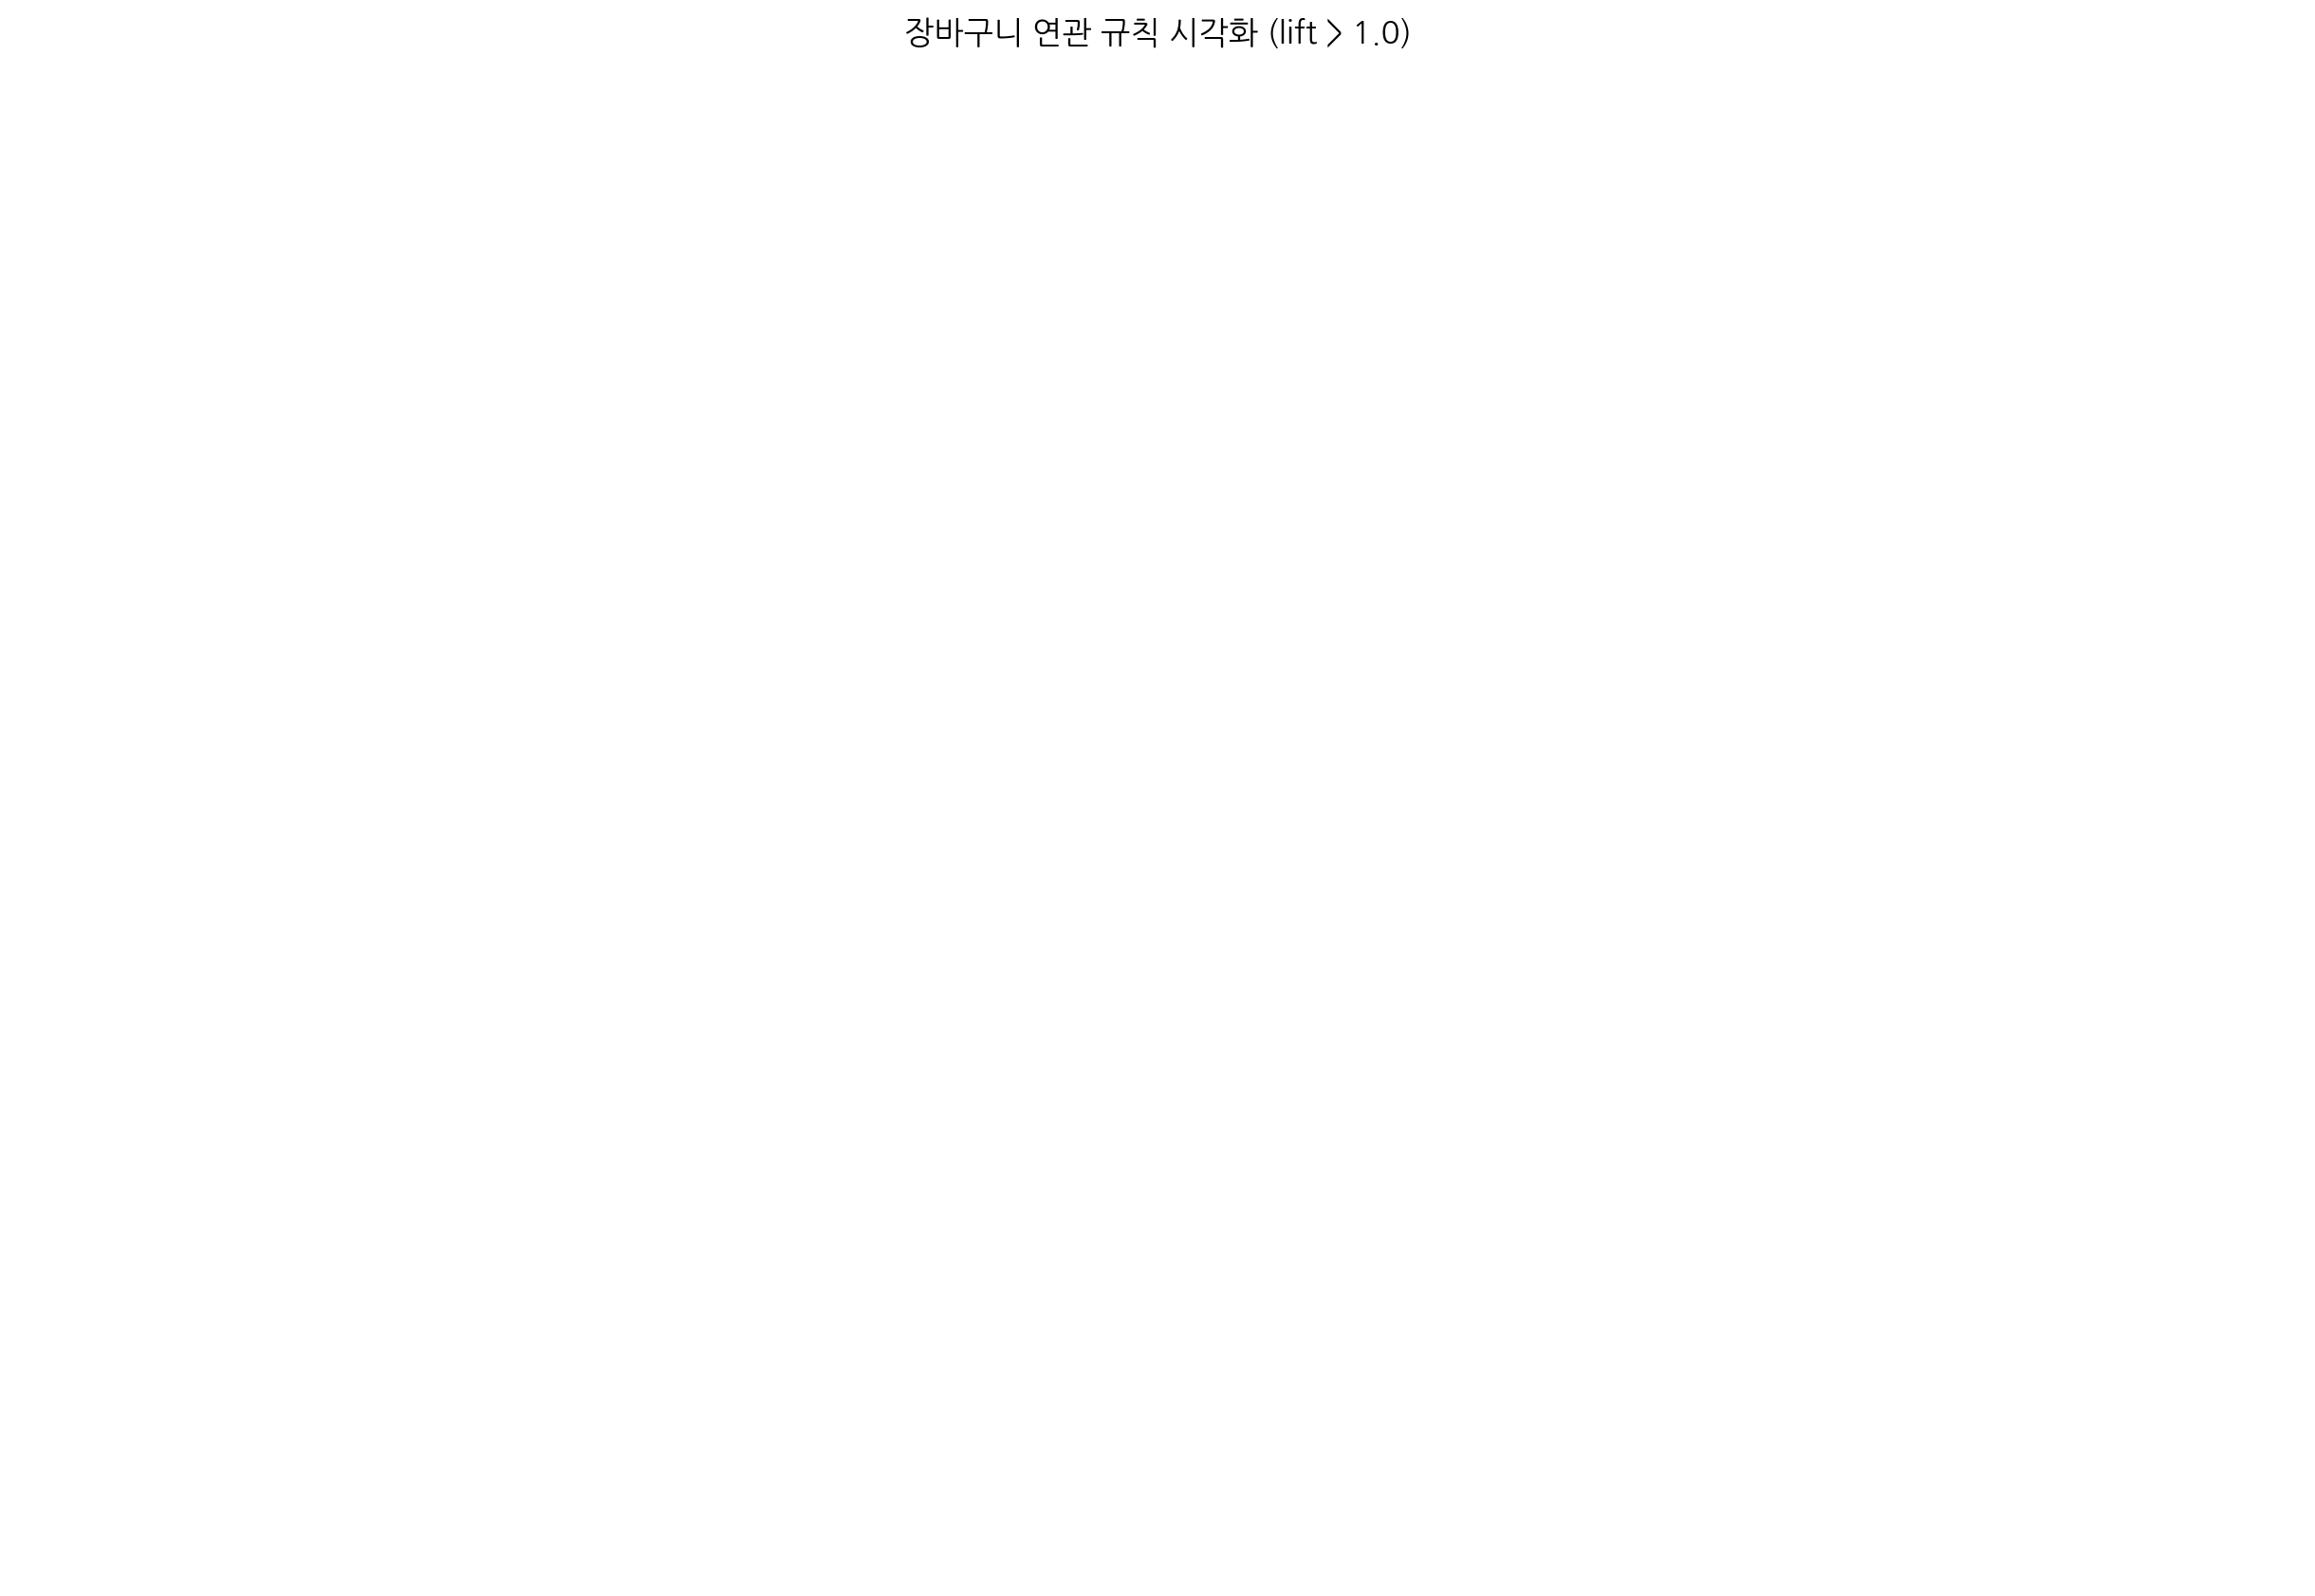

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt



# 그래프 생성
G = nx.DiGraph()


# 시각화
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, edge_color="gray", arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title("장바구니 연관 규칙 시각화 (lift > 1.0)")
plt.axis("off")
plt.show()
